# Introduction
This notebook provides an series of examples of using machine learning to analyze defects from electron microscopy images. The defects come from irradiated steels and have multiples types, which include two types of dislocation loos (111, 100) and so-called black-dot defects, which look like black dots and are likely clusters of interstitials. We explore 4 types of analysis.  
* Classification of defects with FCN (uses images which each have one defect)
* Classification of defects with CNN (uses images which each have one defect) to show power of CNN vs. FCN.
* Classification of defects with VGG16 backbone CNN (uses images which each have one defect) to show power of transfer learning.
* Object detection of each defect with YOLO (uses images with many defects).

This tutorial make use of NNs from TensorFlow and YOLO.
Learning Goals:
* Set up a classification or object deteection calculation in Colab.
* Build, train, and assess a simple FCN, CNN, and transfer learning classification network using Keras/TensorFlow.
* Apply and assess YOLO for object detection.
* Understand the value of CNNs vs. FCNs and tansfer learning vs. randomly initialized NNs for image analysis.
* Understand the differences between classification and object detection.


# Section 0: Setup; Importing and examining images of defects

First, we need to mount our Google drive so we can access the data

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Here, we import all of the needed modules we'll be using in this notebook. Tensorflow/Keras will be used to build the networks. Scikit-learn will be useful for computing some metrics, matplotlib and seaborn will be used for plotting, and os, PIL and numpy are useful for a number of general operations.

In [2]:
import os
import shutil
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import SGD, Adam

First, we need to load in the images and prepare them for fitting to the fully connected network.

First, we need to load in the images and prepare them for fitting to the fully connected network.

If you get an error here that means your google drive is not configured correctly. Please see the instructions here for adding a shortcut for the Bootcamp files to your "Mydrive"
https://docs.google.com/document/d/1cQAASiwEHIv41tbnsuQrHGs9JxXb0W0XM2aX85VwoOI/edit  

The file structure should be:
MyDrive/ML4M - Bootcamp - Summer 2023/Day2/

Inside the Day2 directory you should see a number of files including the zip file loaded in below.

In [5]:
dirpath = os.getcwd()
#shutil.copy('./all_cropped_64px.zip', dirpath)
#!unzip './all_cropped_64px.zip'

Define the paths where the images are stored, and define the class names. Here, we are working with 3 defect types: <111> loops (called "111"), <100> loops (called "100"), and black dots (called "bd")

In [6]:
PATH = os.path.join(dirpath, 'all_cropped_64px')
PATH_111 = os.path.join(PATH, 'train/111')
PATH_100 = os.path.join(PATH, 'train/100')
PATH_bd = os.path.join(PATH, 'train/bd')
class_names = ['111', '100', 'bd']

Get the paths of all the images so we can load them in

In [7]:
files_111 = os.listdir(PATH_111)
files_100 = os.listdir(PATH_100)
files_bd = os.listdir(PATH_bd)
print(len(files_111), len(files_100), len(files_bd))

paths_111 = [os.path.join(PATH_111, f) for f in files_111]
paths_100 = [os.path.join(PATH_100, f) for f in files_100]
paths_bd = [os.path.join(PATH_bd, f) for f in files_bd]

paths_all = np.concatenate([paths_111, paths_100, paths_bd])

4234 2453 5349


Define the y (target) data. Since we are doing classification, each class will have its own number. Here, we simply define 111 loops are class 0, 100 loops are class 1, and black dots are class 2.

In [8]:
y_111 = [0 for i in range(len(files_111))]
y_100 = [1 for i in range(len(files_100))]
y_bd = [2 for i in range(len(files_bd))]
y_all = np.concatenate([y_111, y_100, y_bd])
y_all[0]

0

We need to turn the class labels into a categorical (one hot) vector so that Keras can process it correctly. We can do this with the keras.utils.to_categorical function. You can now see that the first y entry is no longer "0", but now the vector "[1 0 0]", where the "1" in the first index indicates it is class 0 (a 111 loop).

In [9]:
num_categories = 3
y_all = keras.utils.to_categorical(y_all, num_categories)
y_all[0]

array([1., 0., 0.], dtype=float32)

Here, we randomly select images of each defect type and display them to get a feel for what these defects look like.

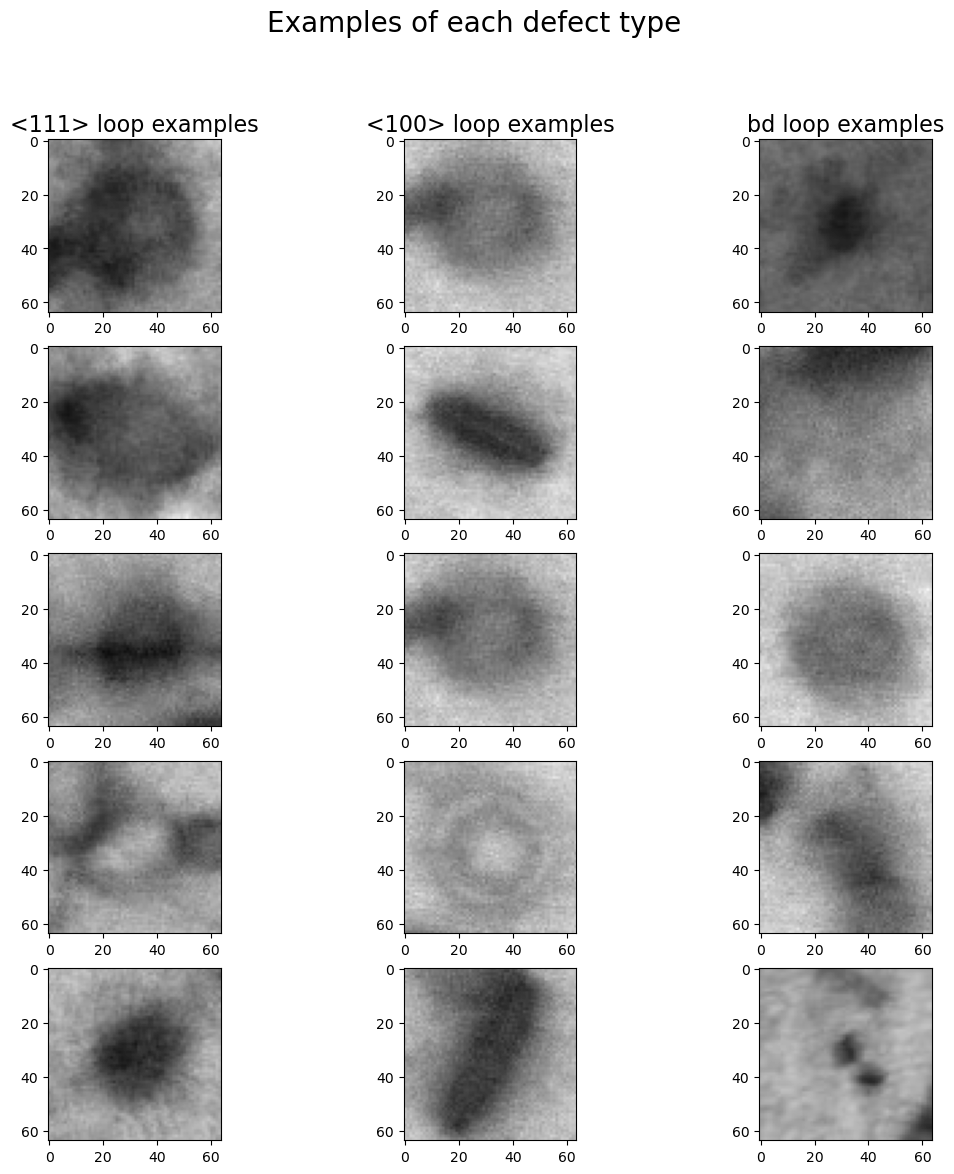

In [10]:
im_111 = [Image.open(os.path.join(PATH_111, files_111[np.random.randint(0, len(files_111))])).convert('L'),
          Image.open(os.path.join(PATH_111, files_111[np.random.randint(0, len(files_111))])).convert('L'),
          Image.open(os.path.join(PATH_111, files_111[np.random.randint(0, len(files_111))])).convert('L'),
          Image.open(os.path.join(PATH_111, files_111[np.random.randint(0, len(files_111))])).convert('L'),
          Image.open(os.path.join(PATH_111, files_111[np.random.randint(0, len(files_111))])).convert('L')]
im_100 = [Image.open(os.path.join(PATH_100, files_100[np.random.randint(0, len(files_100))])).convert('L'),
          Image.open(os.path.join(PATH_100, files_100[np.random.randint(0, len(files_100))])).convert('L'),
          Image.open(os.path.join(PATH_100, files_100[np.random.randint(0, len(files_100))])).convert('L'),
          Image.open(os.path.join(PATH_100, files_100[np.random.randint(0, len(files_100))])).convert('L'),
          Image.open(os.path.join(PATH_100, files_100[np.random.randint(0, len(files_100))])).convert('L')]
im_bd = [Image.open(os.path.join(PATH_bd, files_bd[np.random.randint(0, len(files_bd))])).convert('L'),
          Image.open(os.path.join(PATH_bd, files_bd[np.random.randint(0, len(files_bd))])).convert('L'),
          Image.open(os.path.join(PATH_bd, files_bd[np.random.randint(0, len(files_bd))])).convert('L'),
          Image.open(os.path.join(PATH_bd, files_bd[np.random.randint(0, len(files_bd))])).convert('L'),
          Image.open(os.path.join(PATH_bd, files_bd[np.random.randint(0, len(files_bd))])).convert('L')]

fig, axs = plt.subplots(len(im_111), 3)
fig.set_figheight(13)
fig.set_figwidth(13)
fig.suptitle('Examples of each defect type', fontsize=20)
for i, im in enumerate(im_111):
    axs[i][0].imshow(im, cmap='gray',vmin=0, vmax=255)
    axs[0][0].set_title('<111> loop examples', fontsize=16)
for i, im in enumerate(im_100):
    axs[i][1].imshow(im, cmap='gray',vmin=0, vmax=255)
    axs[0][1].set_title('<100> loop examples', fontsize=16)
for i, im in enumerate(im_bd):
    axs[i][2].imshow(im, cmap='gray',vmin=0, vmax=255)
    axs[0][2].set_title('bd loop examples', fontsize=16)


As you can see, the images are 64x64 pixels and generally consist of darker defects laid against a lighter background. These defects were imaged with Scanning Transmission Electron Microscopy (STEM) in bright field condition. There are some general characteristics of each defect type which makes them distinct:

<111> loops: dark, elliptical loops that are commonly situated at an angle (e.g., 45 degrees

<100> loops: either lighter, circular loops (face-on orientation), or dark, wedge-shaped defects (edge-on orientation)

black dots: circular dark blobs

# Section 1: Defect classification with fully connected network (FCN)

Next, we need to read in all the images as arrays and reshape them from 64x64 pixels to flat vectors of length 4096. This is fast on a local machine but slow on Google Colab, so we can simply import the already-reshaped images from Google drive.

In [12]:
# Note that this can take upwards of 26 min on Google Colab for whatever reason (takes only seconds on my computer though)
#images_all = list()
#for f in paths_all:
#    im = Image.open(f).convert('L')
#    images_all.append(np.array(im).reshape(64**2))
#images_all = np.array(images_all)
#images_all = images_all / 255

# Instead, we can load the saved array of images after I processed them once:
images_all = np.load(os.path.join('images_all.npy'))

We need to split our image data into a set of training images and a set of images to test our model on (here, called validation). We can do this with scikit-learn's train_test_split function. Here, we select a test_size of 0.1, or 10% of the images, and set the random_state variable so the same images are used in training and testing to have repeatability

In [13]:
X_train, X_val, y_train, y_val = train_test_split(images_all, y_all, shuffle='True', random_state=42, test_size=0.1)

Let's check the sizes of the resulting arrays. Our training data has 10,832 images, and our validation set has 1204 images. The shape of the images is 1D of size 4096, as we previously reshaped the images from 64x64 to 4096, a necessary step for using the fully connected layer as we start out.

In [14]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(10832, 4096) (1204, 4096) (10832, 3) (1204, 3)


It is now time to build the neural network. We build a basic, 2 layer fully connected neural network. We will have 16 nodes in the first layer. This could be larger and more layers could be used, but we are keeping it simple. For the final layer we have one node for each of classes (here 3). We use softmax for the activation function. This effectively lets each of the final nodes to represent one class, and it will turn on (i.e., return close to 1) when the model predicts that class it present. We build this network by building a Sequential() Keras model, with the Dense() class to represent the individual layers. Note that adding more nodes or layers gives modest increases and much larger and slower to train models (we encourage you to explore this).





In [15]:
model_dense = Sequential()
model_dense.add(Dense(units=16, activation='relu', input_shape=(4096,)))
model_dense.add(Dense(units=16, activation='relu', input_shape=(4096,)))

In [16]:
model_dense.add(Dense(units=3, activation='softmax'))

We can print out a summary of our network, seeing that we have just over 65k training parameters

In [17]:
model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                65552     
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 65875 (257.32 KB)
Trainable params: 65875 (257.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We compile the network, using the Adam optimizer and categorical crossentropy as a loss function, which works well for classification problems like the present one.

In [18]:
model_dense.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Finally, we define some useful callback functions that will help with early stopping to avoid over training, a model checkpointer to save the fit model, and a learning rate reducer to help with more stable training. The early stopping occurs when the validation accuracy does not decrease for "patience" steps.

In [19]:
model_folder = 'model_dense_1layer'
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
mcp_save = ModelCheckpoint(os.path.join(dirpath, model_folder), restore_best_weights=True, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')

Now we train the model:

In [20]:
history_dense = model_dense.fit(X_train,
                                y_train,
                                epochs=50,
                                verbose=1,
                                steps_per_epoch=len(X_train)/32, # Run same number of steps we would if we were not using a generator.
                                validation_data=(X_val, y_val),
                                callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/50


308/338 [==========================>...] - ETA: 0s - loss: 0.9366 - accuracy: 0.5875INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


338/338 [==============================] - 2s 4ms/step - loss: 0.9272 - accuracy: 0.5949 - val_loss: 0.8412 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 2/50
317/338 [===========================>..] - ETA: 0s - loss: 0.8090 - accuracy: 0.6779INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


338/338 [==============================] - 1s 3ms/step - loss: 0.8078 - accuracy: 0.6786 - val_loss: 0.7689 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 3/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7836 - accuracy: 0.6809 - val_loss: 0.8223 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 4/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7704 - accuracy: 0.6838 - val_loss: 0.7387 - val_accuracy: 0.6894 - lr: 0.0010
Epoch 5/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7599 - accuracy: 0.6834 - val_loss: 0.7585 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 6/50
326/338 [===========================>..] - ETA: 0s - loss: 0.7600 - accuracy: 0.6860INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


338/338 [==============================] - 1s 3ms/step - loss: 0.7598 - accuracy: 0.6862 - val_loss: 0.7304 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 7/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7592 - accuracy: 0.6857 - val_loss: 0.7326 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 8/50
332/338 [============================>.] - ETA: 0s - loss: 0.7457 - accuracy: 0.6894INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


338/338 [==============================] - 1s 3ms/step - loss: 0.7470 - accuracy: 0.6893 - val_loss: 0.7254 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 9/50
313/338 [==========================>...] - ETA: 0s - loss: 0.7419 - accuracy: 0.6917INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


338/338 [==============================] - 1s 3ms/step - loss: 0.7427 - accuracy: 0.6907 - val_loss: 0.7234 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 10/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7550 - accuracy: 0.6856 - val_loss: 0.7278 - val_accuracy: 0.6927 - lr: 0.0010
Epoch 11/50
316/338 [===========================>..] - ETA: 0s - loss: 0.7507 - accuracy: 0.6845INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\model_dense_1layer\assets


338/338 [==============================] - 1s 3ms/step - loss: 0.7491 - accuracy: 0.6860 - val_loss: 0.7215 - val_accuracy: 0.7018 - lr: 0.0010
Epoch 12/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7437 - accuracy: 0.6899 - val_loss: 0.7539 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 13/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7403 - accuracy: 0.6930 - val_loss: 0.7297 - val_accuracy: 0.6919 - lr: 0.0010
Epoch 14/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7403 - accuracy: 0.6917 - val_loss: 0.7264 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 15/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7406 - accuracy: 0.6905 - val_loss: 0.7308 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 16/50
325/338 [===========================>..] - ETA: 0s - loss: 0.7403 - accuracy: 0.6882
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
338/338 [==============================] - 1s 2ms/step - 

Here, we plot the training and validation accuracy as a function of epochs to examine how the training went. The training accuracy leveled out around 69%, and the validation accuracy is slightly lower, which is common training behavior.

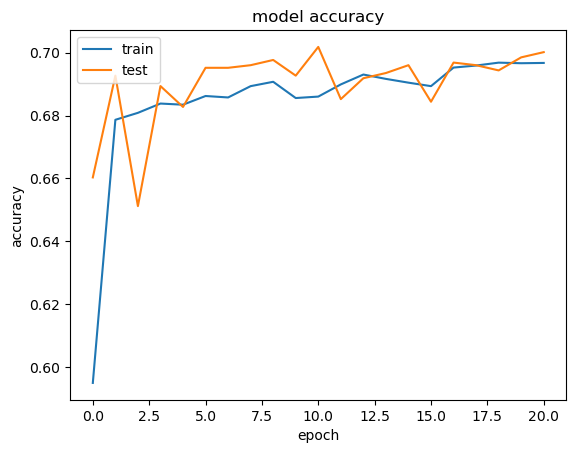

In [21]:
plt.plot(history_dense.history['accuracy'])
plt.plot(history_dense.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(model_folder, 'model_dense_training.png'), dpi=300, bbox_inches='tight')
plt.show()

Here, we load in the best performing fully connected model and calculate some key performance metrics. These metrics include the overall classification accuracy, and the classification F1 scores for each type of defect. We can see that the average F1 score is low, around 0.5, and essentially no ability to classify the <100> loops, which are the most difficult defect type to classify correctly.

In [22]:
model_dense_best = keras.models.load_model(model_folder)

preds = model_dense_best.predict(X_val)
y_true = np.argmax(y_val, axis=1)
y_pred_dense = np.argmax(preds, axis=1)
model_dense_acc = accuracy_score(y_true, y_pred_dense)
print('Validation accuracy=', model_dense_acc)

p_r_f1 = precision_recall_fscore_support(y_true, y_pred_dense, labels=[0, 1, 2])
print('F1 scores:')
print('111 F1 = ', p_r_f1[2][0])
print('100 F1 = ', p_r_f1[2][1])
print('bd F1 = ', p_r_f1[2][2])
print('Average F1 score = ', np.mean([p_r_f1[2][0], p_r_f1[2][1], p_r_f1[2][2]]))


38/38 [==============================] - 0s 1ms/step
Validation accuracy= 0.7018272425249169
F1 scores:
111 F1 =  0.7152173913043479
100 F1 =  0.0
bd F1 =  0.8255999999999999
Average F1 score =  0.5136057971014493


C:\Users\jhyan\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finally, we can make the confusion matrix to assess the types of false positives and negatives made by the model.

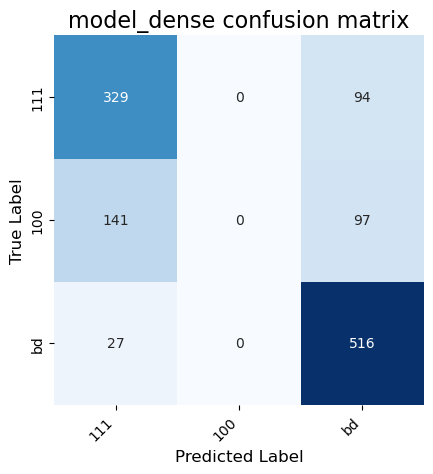

In [23]:
cm = confusion_matrix(y_true, y_pred_dense, labels=[0, 1, 2])
ax = sns.heatmap(cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False)
ax.set_title('model_dense confusion matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.savefig(os.path.join(model_folder, 'model_dense_confusionmatrix.png'), dpi=300, bbox_inches='tight')

As we can see, this simple dense model completely fails to categorize the <100> loops, and the model has a low F1 score of only 0.5.

We can zip up the folder containing our dense model and the analysis plots we just made, making it easier to download for future use.

In [24]:
!zip -r {model_folder}'.zip' {model_folder}

  adding: model_dense_1layer/ (164 bytes security) (stored 0%)
  adding: model_dense_1layer/assets/ (164 bytes security) (stored 0%)
  adding: model_dense_1layer/fingerprint.pb (164 bytes security) (stored 0%)
  adding: model_dense_1layer/keras_metadata.pb (164 bytes security) (deflated 87%)
  adding: model_dense_1layer/model_dense_confusionmatrix.png (164 bytes security) (deflated 18%)
  adding: model_dense_1layer/model_dense_training.png (164 bytes security) (deflated 13%)
  adding: model_dense_1layer/saved_model.pb (164 bytes security) (deflated 86%)
  adding: model_dense_1layer/variables/ (164 bytes security) (stored 0%)
  adding: model_dense_1layer/variables/variables.data-00000-of-00001 (164 bytes security) (deflated 21%)
  adding: model_dense_1layer/variables/variables.index (164 bytes security) (deflated 60%)


# Section 2: Defect classification with a convolutional neural network (CNN)

For fitting our CNN, we will use the same train and validation data as we did for our fully connected network. Unlike the fully connected network, the CNN needs the data in the original shape of 64x64 pixels, so we reshape the data here:

In [25]:
X_train = X_train.reshape(-1, 64, 64, 1)
X_val = X_val.reshape(-1, 64, 64, 1)

We see that the training data consists of 10,832 images, of size 64x64, with a single color channel (i.e., they are grayscale)

In [26]:
X_train.shape

(10832, 64, 64, 1)

Here, we define the architecture of our CNN model. We have 3 blocks of convolutions, which are typically followed by a batch normalization and max pooling operation. Here, the convolution layers use a 3x3 window with progressively decreasing numbers of kernels (first 75, then 50, finally 25). The max pool operations effectively reduce the dimensionality of the feature space by factors of 2 each time they are called. This a typical architecture of a CNN block and other structures could yield better results.

In [27]:
model_cnn = Sequential()

model_cnn.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(64, 64, 1)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model_cnn.add(Dropout(0.2))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn.add(Flatten())


After our CNN layers, we have a flattened vector of descriptors of the image. This vector, rather than being the actual image pixel intensities as was used for the fully connected network in Section 1, are the values obtained from the convolution and max pooling operations. Here, we add the same fully connected network to perform the classification as we used in Section 1:

In [28]:
model_cnn.add(Dense(units=16, activation="relu"))
model_cnn.add(Dense(units=3, activation="softmax"))

As before, we can inspect the summary of our model. It has a total of about 72k trainable parameters, only 7k more than our fully connected network. However, we will see that using a CNN as opposed to a fully connected network, while not having many more parameters, will make a big differnece in the classification performance.

In [29]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 32, 32, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 50)       

Same as in Section 1, we compile our model and define some handy callback functions to help the training and model saving process.

In [30]:
model_cnn.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [31]:
model_folder = 'model_cnn_small'
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
mcp_save = ModelCheckpoint(model_folder, restore_best_weights=True, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')

In [32]:
history_cnn = model_cnn.fit(X_train,
                            y_train,
                            epochs=100,
                            verbose=1,
                            steps_per_epoch=len(X_train)/32, # Run same number of steps we would if we were not using a generator.
                            validation_data=(X_val, y_val),
                            callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/100
338/338 [============================>.] - ETA: 0s - loss: 0.7307 - accuracy: 0.6941INFO:tensorflow:Assets written to: model_cnn_small\assets


INFO:tensorflow:Assets written to: model_cnn_small\assets


338/338 [==============================] - 29s 84ms/step - loss: 0.7304 - accuracy: 0.6942 - val_loss: 1.1473 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 2/100
339/338 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.7480INFO:tensorflow:Assets written to: model_cnn_small\assets


INFO:tensorflow:Assets written to: model_cnn_small\assets


338/338 [==============================] - 31s 91ms/step - loss: 0.6204 - accuracy: 0.7480 - val_loss: 0.8778 - val_accuracy: 0.6445 - lr: 0.0010
Epoch 3/100
339/338 [==============================] - ETA: 0s - loss: 0.5765 - accuracy: 0.7667INFO:tensorflow:Assets written to: model_cnn_small\assets


INFO:tensorflow:Assets written to: model_cnn_small\assets


338/338 [==============================] - 32s 93ms/step - loss: 0.5765 - accuracy: 0.7667 - val_loss: 0.6156 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 4/100
338/338 [==============================] - 32s 94ms/step - loss: 0.5457 - accuracy: 0.7831 - val_loss: 0.6984 - val_accuracy: 0.7118 - lr: 0.0010
Epoch 5/100
338/338 [==============================] - 29s 85ms/step - loss: 0.5179 - accuracy: 0.7902 - val_loss: 2.9802 - val_accuracy: 0.4086 - lr: 0.0010
Epoch 6/100
338/338 [==============================] - 28s 83ms/step - loss: 0.5015 - accuracy: 0.7998 - val_loss: 0.6752 - val_accuracy: 0.7027 - lr: 0.0010
Epoch 7/100
338/338 [==============================] - 28s 82ms/step - loss: 0.4740 - accuracy: 0.8079 - val_loss: 1.3726 - val_accuracy: 0.6113 - lr: 0.0010
Epoch 8/100
338/338 [============================>.] - ETA: 0s - loss: 0.4543 - accuracy: 0.8182
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
338/338 [==============================] - 30s 9

INFO:tensorflow:Assets written to: model_cnn_small\assets


338/338 [==============================] - 32s 96ms/step - loss: 0.3952 - accuracy: 0.8422 - val_loss: 0.5868 - val_accuracy: 0.7699 - lr: 1.0000e-04
Epoch 10/100
338/338 [==============================] - 32s 94ms/step - loss: 0.3767 - accuracy: 0.8522 - val_loss: 0.5933 - val_accuracy: 0.7699 - lr: 1.0000e-04
Epoch 11/100
338/338 [============================>.] - ETA: 0s - loss: 0.3680 - accuracy: 0.8553INFO:tensorflow:Assets written to: model_cnn_small\assets


INFO:tensorflow:Assets written to: model_cnn_small\assets


338/338 [==============================] - 29s 84ms/step - loss: 0.3680 - accuracy: 0.8553 - val_loss: 0.5981 - val_accuracy: 0.7724 - lr: 1.0000e-04
Epoch 12/100
338/338 [============================>.] - ETA: 0s - loss: 0.3576 - accuracy: 0.8621INFO:tensorflow:Assets written to: model_cnn_small\assets


INFO:tensorflow:Assets written to: model_cnn_small\assets


338/338 [==============================] - 28s 83ms/step - loss: 0.3582 - accuracy: 0.8619 - val_loss: 0.5843 - val_accuracy: 0.7782 - lr: 1.0000e-04
Epoch 13/100
338/338 [==============================] - 27s 78ms/step - loss: 0.3505 - accuracy: 0.8620 - val_loss: 0.6093 - val_accuracy: 0.7666 - lr: 1.0000e-04
Epoch 14/100
338/338 [==============================] - 26s 78ms/step - loss: 0.3459 - accuracy: 0.8660 - val_loss: 0.6215 - val_accuracy: 0.7674 - lr: 1.0000e-04
Epoch 15/100
338/338 [==============================] - 26s 78ms/step - loss: 0.3397 - accuracy: 0.8688 - val_loss: 0.6699 - val_accuracy: 0.7434 - lr: 1.0000e-04
Epoch 16/100
338/338 [==============================] - 26s 78ms/step - loss: 0.3334 - accuracy: 0.8684 - val_loss: 0.6034 - val_accuracy: 0.7724 - lr: 1.0000e-04
Epoch 17/100
338/338 [============================>.] - ETA: 0s - loss: 0.3290 - accuracy: 0.8708INFO:tensorflow:Assets written to: model_cnn_small\assets


INFO:tensorflow:Assets written to: model_cnn_small\assets


338/338 [==============================] - 29s 85ms/step - loss: 0.3288 - accuracy: 0.8708 - val_loss: 0.5856 - val_accuracy: 0.7882 - lr: 1.0000e-04
Epoch 18/100
338/338 [==============================] - 27s 80ms/step - loss: 0.3202 - accuracy: 0.8756 - val_loss: 0.5955 - val_accuracy: 0.7766 - lr: 1.0000e-04
Epoch 19/100
338/338 [==============================] - 26s 77ms/step - loss: 0.3125 - accuracy: 0.8781 - val_loss: 0.5981 - val_accuracy: 0.7824 - lr: 1.0000e-04
Epoch 20/100
338/338 [==============================] - 26s 76ms/step - loss: 0.3107 - accuracy: 0.8781 - val_loss: 0.5990 - val_accuracy: 0.7782 - lr: 1.0000e-04
Epoch 21/100
338/338 [==============================] - 31s 91ms/step - loss: 0.3005 - accuracy: 0.8828 - val_loss: 0.6519 - val_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 22/100
338/338 [============================>.] - ETA: 0s - loss: 0.2951 - accuracy: 0.8849
Epoch 22: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
338/338 [=============

Here we plot the training and validation accuracy to assess how the model training went.

After ~20 epochs with a CNN, the training accuracy is ~85% while the highest validation accuracy is about 77%. This is an improvement over the fully connected network, but indicates there is some significant overfitting occurring.


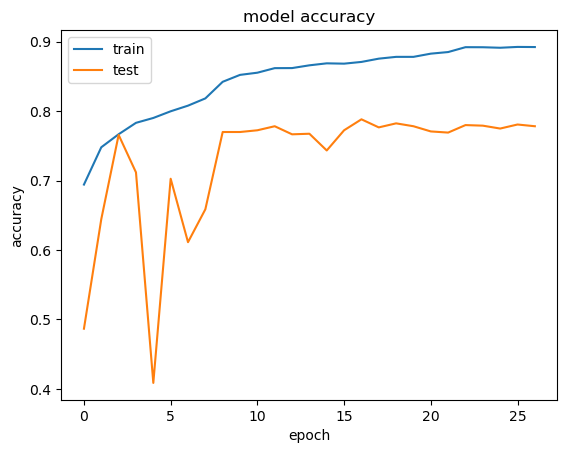

In [33]:
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(model_folder, 'model_cnn_training.png'), dpi=300, bbox_inches='tight')
plt.show()

Here, we load in the best performing CNN model and calculate some key performance metrics.

We can see that the average F1 score is much higher than the fully connected network, now about 0.72 instead of 0.5. The model can also now classify the <100> loops, though these have the lowest F1 score of the three defect types as they are the most difficult defect type to classify correctly.

In [34]:
model_cnn_best = keras.models.load_model(model_folder)

preds = model_cnn_best.predict(X_val)
y_true = np.argmax(y_val, axis=1)
y_pred_cnn = np.argmax(preds, axis=1)
model_cnn_acc = accuracy_score(y_true, y_pred_cnn)
print('Validation accuracy=', model_cnn_acc)

p_r_f1 = precision_recall_fscore_support(y_true, y_pred_cnn, labels=[0, 1, 2])
print('F1 scores:')
print('111 F1 = ', p_r_f1[2][0])
print('100 F1 = ', p_r_f1[2][1])
print('bd F1 = ', p_r_f1[2][2])
print('Average F1 score = ', np.mean([p_r_f1[2][0], p_r_f1[2][1], p_r_f1[2][2]]))


38/38 [==============================] - 1s 21ms/step
Validation accuracy= 0.7882059800664452
F1 scores:
111 F1 =  0.7707082833133253
100 F1 =  0.5665024630541872
bd F1 =  0.8776732249786143
Average F1 score =  0.7382946571153756


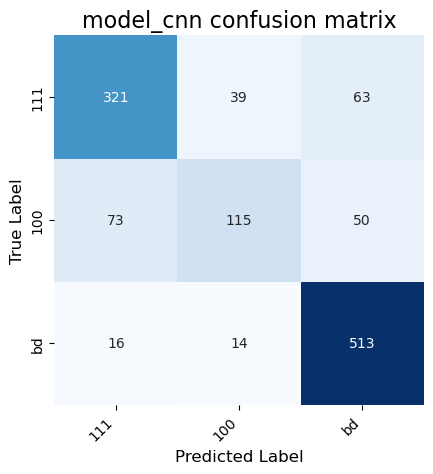

In [35]:
cm = confusion_matrix(y_true, y_pred_cnn, labels=[0, 1, 2])
ax = sns.heatmap(cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False)
ax.set_title('model_cnn confusion matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.savefig(os.path.join(model_folder, 'model_cnn_confusionmatrix.png'), dpi=300, bbox_inches='tight')

We can see that adding the CNN layers on top of our fully connected network resulted in
much improved features and performance, with accuracy increasing from ~69% to ~76%, and,
more importantly, a much improved F1 score of 0.72 vs. the 0.5 value from the fully connected network. This improvement in performance is pretty drastic considering the CNN only has a few thousand more parameters than the fully connected network.

As mentioned above, our CNN showed signs of overfitting. We can run the CNN again but include data augmentation to stabilize the training procedure.

As before, we can zip our CNN folder for easier downloading

In [36]:
!zip -r {model_folder}.zip {model_folder}

  adding: model_cnn_small/ (164 bytes security) (stored 0%)
  adding: model_cnn_small/assets/ (164 bytes security) (stored 0%)
  adding: model_cnn_small/fingerprint.pb (164 bytes security) (stored 0%)
  adding: model_cnn_small/keras_metadata.pb (164 bytes security) (deflated 92%)
  adding: model_cnn_small/model_cnn_confusionmatrix.png (164 bytes security) (deflated 18%)
  adding: model_cnn_small/model_cnn_training.png (164 bytes security) (deflated 12%)
  adding: model_cnn_small/saved_model.pb (164 bytes security) (deflated 88%)
  adding: model_cnn_small/variables/ (164 bytes security) (stored 0%)
  adding: model_cnn_small/variables/variables.data-00000-of-00001 (164 bytes security) (deflated 8%)
  adding: model_cnn_small/variables/variables.index (164 bytes security) (deflated 66%)


# Section 3: Improved CNN training with data augmentation and dropout



There are two key methods to help solve the issue of overfitting observed in our CNN model from Section 2.

The first is adding dropout, which are additional layers in our CNN which randomly remove certain node connections at each step of training, thus adding more variety to the weights used in each iteration of training.

The second is data augmentation, which are image operations such as flipping, rotation, cropping, applied to the set of training images to add more variety to the images the model sees in training, and is essentially an artificial method of expanding the training data.

To implement data augmentation for our CNN, we need to use the ImageDataGenerator class in Keras:

In [37]:
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)

We use the .flow() method to create batches of augmented training data. We do this and show a set of input images after augmentation

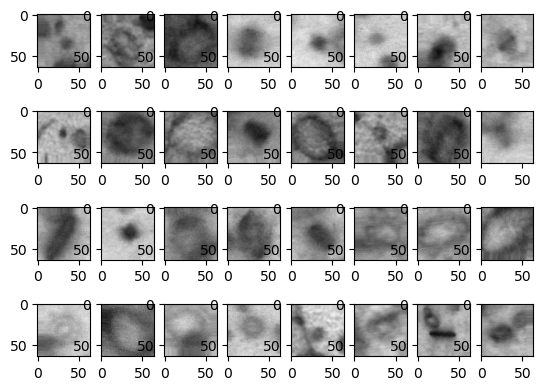

In [38]:
batch_size = 32
img_iter = datagen.flow(X_train, y_train, batch_size=batch_size)
datagen.fit(X_train)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image), cmap='gray', vmin=0, vmax=1)
plt.show()

Here, we define the same CNN architecture that we used in Section 2:

In [39]:
model_cnn_aug = Sequential()

model_cnn_aug.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(64, 64, 1)))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn_aug.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model_cnn_aug.add(Dropout(0.2))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn_aug.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn_aug.add(Flatten())

We again use the same fully connected network as last time, but we add a dropout layer right before the final classification step.

In [40]:
model_cnn_aug.add(Dense(units=16, activation="relu"))
model_cnn_aug.add(Dropout(0.3))
model_cnn_aug.add(Dense(units=3, activation="softmax"))

In [41]:
model_cnn_aug.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 75)        750       
                                                                 
 batch_normalization_3 (Bat  (None, 64, 64, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 50)        33800     
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 50)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 32, 32, 50)       

We compile and define the same callbacks for this model as we did in the previous two sections

In [42]:
model_cnn_aug.compile(optimizer=Adam(learning_rate=1e-2), loss="categorical_crossentropy", metrics=["accuracy"])

In [43]:
model_folder = 'model_cnn_aug'
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
mcp_save = ModelCheckpoint(model_folder, restore_best_weights=True, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')

Here, when fitting hte model we set a higher number of epochs. The model will need more epochs to improve its accuracy as the addition of dropout and data augmentation add more variation to the training, necessitating a longer training schedule to reach desired performance.

Note that longer training of this model beyond 30 epochs will result in improved performance. Here, we restrict ourselves to 30 epochs at first to keep the training time < 5 minutes.

In [44]:
history_cnn_aug = model_cnn_aug.fit(img_iter,
          epochs=30,
          steps_per_epoch=len(X_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_val, y_val),
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/30
339/338 [==============================] - ETA: 0s - loss: 0.9452 - accuracy: 0.5738INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 31s 87ms/step - loss: 0.9452 - accuracy: 0.5738 - val_loss: 0.8469 - val_accuracy: 0.6719 - lr: 0.0100
Epoch 2/30
339/338 [==============================] - ETA: 0s - loss: 0.8411 - accuracy: 0.6373INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 31s 93ms/step - loss: 0.8411 - accuracy: 0.6373 - val_loss: 0.7395 - val_accuracy: 0.6968 - lr: 0.0100
Epoch 3/30
339/338 [==============================] - ETA: 0s - loss: 0.8122 - accuracy: 0.6508INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 29s 86ms/step - loss: 0.8122 - accuracy: 0.6508 - val_loss: 0.7497 - val_accuracy: 0.7151 - lr: 0.0100
Epoch 4/30
338/338 [==============================] - 28s 83ms/step - loss: 0.7871 - accuracy: 0.6690 - val_loss: 0.7548 - val_accuracy: 0.6786 - lr: 0.0100
Epoch 5/30
339/338 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.6735INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 28s 83ms/step - loss: 0.7671 - accuracy: 0.6735 - val_loss: 0.7276 - val_accuracy: 0.7168 - lr: 0.0100
Epoch 6/30
339/338 [==============================] - ETA: 0s - loss: 0.7583 - accuracy: 0.6820INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 30s 87ms/step - loss: 0.7583 - accuracy: 0.6820 - val_loss: 0.6555 - val_accuracy: 0.7193 - lr: 0.0100
Epoch 7/30
339/338 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.6840INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 29s 86ms/step - loss: 0.7472 - accuracy: 0.6840 - val_loss: 0.6736 - val_accuracy: 0.7301 - lr: 0.0100
Epoch 8/30
338/338 [==============================] - 28s 83ms/step - loss: 0.7396 - accuracy: 0.6913 - val_loss: 0.6484 - val_accuracy: 0.7209 - lr: 0.0100
Epoch 9/30
338/338 [==============================] - 28s 83ms/step - loss: 0.7349 - accuracy: 0.6927 - val_loss: 0.6910 - val_accuracy: 0.7018 - lr: 0.0100
Epoch 10/30
338/338 [==============================] - 28s 83ms/step - loss: 0.7280 - accuracy: 0.6989 - val_loss: 0.6694 - val_accuracy: 0.7126 - lr: 0.0100
Epoch 11/30
339/338 [==============================] - ETA: 0s - loss: 0.7170 - accuracy: 0.7025INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 30s 88ms/step - loss: 0.7170 - accuracy: 0.7025 - val_loss: 0.6243 - val_accuracy: 0.7392 - lr: 0.0100
Epoch 12/30
339/338 [==============================] - ETA: 0s - loss: 0.7041 - accuracy: 0.7087INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 29s 86ms/step - loss: 0.7041 - accuracy: 0.7087 - val_loss: 0.6007 - val_accuracy: 0.7583 - lr: 0.0100
Epoch 13/30
338/338 [==============================] - 28s 81ms/step - loss: 0.7040 - accuracy: 0.7131 - val_loss: 0.6064 - val_accuracy: 0.7550 - lr: 0.0100
Epoch 14/30
338/338 [==============================] - 28s 83ms/step - loss: 0.6983 - accuracy: 0.7127 - val_loss: 0.6318 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 15/30
338/338 [==============================] - 27s 80ms/step - loss: 0.6889 - accuracy: 0.7185 - val_loss: 0.6031 - val_accuracy: 0.7450 - lr: 0.0100
Epoch 16/30
338/338 [==============================] - 28s 82ms/step - loss: 0.6949 - accuracy: 0.7170 - val_loss: 0.6466 - val_accuracy: 0.7475 - lr: 0.0100
Epoch 17/30
339/338 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.7242
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
338/338 [==============================] - 28s 8

INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 29s 85ms/step - loss: 0.6481 - accuracy: 0.7347 - val_loss: 0.5731 - val_accuracy: 0.7625 - lr: 1.0000e-03
Epoch 19/30
339/338 [==============================] - ETA: 0s - loss: 0.6327 - accuracy: 0.7427INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 29s 87ms/step - loss: 0.6327 - accuracy: 0.7427 - val_loss: 0.5631 - val_accuracy: 0.7733 - lr: 1.0000e-03
Epoch 20/30
338/338 [==============================] - 28s 82ms/step - loss: 0.6294 - accuracy: 0.7443 - val_loss: 0.5675 - val_accuracy: 0.7716 - lr: 1.0000e-03
Epoch 21/30
338/338 [==============================] - 29s 84ms/step - loss: 0.6262 - accuracy: 0.7400 - val_loss: 0.5646 - val_accuracy: 0.7733 - lr: 1.0000e-03
Epoch 22/30
338/338 [==============================] - 29s 87ms/step - loss: 0.6256 - accuracy: 0.7472 - val_loss: 0.5634 - val_accuracy: 0.7716 - lr: 1.0000e-03
Epoch 23/30
339/338 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.7494INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 30s 88ms/step - loss: 0.6196 - accuracy: 0.7494 - val_loss: 0.5667 - val_accuracy: 0.7749 - lr: 1.0000e-03
Epoch 24/30
338/338 [==============================] - 29s 85ms/step - loss: 0.6125 - accuracy: 0.7545 - val_loss: 0.5623 - val_accuracy: 0.7749 - lr: 1.0000e-03
Epoch 25/30
338/338 [==============================] - 28s 83ms/step - loss: 0.6137 - accuracy: 0.7542 - val_loss: 0.5634 - val_accuracy: 0.7724 - lr: 1.0000e-03
Epoch 26/30
339/338 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.7491INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 29s 87ms/step - loss: 0.6177 - accuracy: 0.7491 - val_loss: 0.5566 - val_accuracy: 0.7807 - lr: 1.0000e-03
Epoch 27/30
338/338 [==============================] - 29s 86ms/step - loss: 0.6169 - accuracy: 0.7500 - val_loss: 0.5523 - val_accuracy: 0.7716 - lr: 1.0000e-03
Epoch 28/30
338/338 [==============================] - 28s 81ms/step - loss: 0.6089 - accuracy: 0.7551 - val_loss: 0.5537 - val_accuracy: 0.7674 - lr: 1.0000e-03
Epoch 29/30
338/338 [==============================] - 28s 83ms/step - loss: 0.6108 - accuracy: 0.7543 - val_loss: 0.5508 - val_accuracy: 0.7791 - lr: 1.0000e-03
Epoch 30/30
338/338 [==============================] - 28s 84ms/step - loss: 0.6089 - accuracy: 0.7571 - val_loss: 0.5534 - val_accuracy: 0.7708 - lr: 1.0000e-03


Here we again plot the training and test accuracy for this model. Contrary to our initial CNN, this model's train and test accuracy are much closer, showing that we have less overfitting. While overfitting may not be intrinsically bad, so long as the test accuracy is high, here we actually show that the model accuracy and F1 scores are slightly improved by adding data augmentation and dropout.

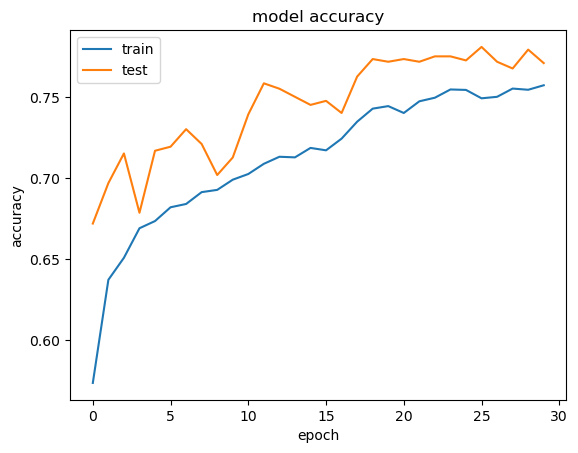

In [45]:
plt.plot(history_cnn_aug.history['accuracy'])
plt.plot(history_cnn_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(model_folder, 'model_cnn_aug_training.png'), dpi=300, bbox_inches='tight')
plt.show()

When evaluating our performance metrics, we can see that the average F1 score is slightly improved compared to Section 2, with a value of 0.735 instead of 0.72.

The model also has a slightly higher accuracy compared to Section 2, with a value of about 79% instead of 76%

In [46]:
# Load the best saved model and compute the validation accuracy
model_cnn_aug_best = keras.models.load_model(os.path.join(dirpath, 'model_cnn_aug'))

preds = model_cnn_aug_best.predict(X_val)
y_true = np.argmax(y_val, axis=1)
y_pred_cnn_aug = np.argmax(preds, axis=1)
model_cnn_aug_acc = accuracy_score(y_true, y_pred_cnn_aug)
print('Validation accuracy=', model_cnn_aug_acc)

p_r_f1 = precision_recall_fscore_support(y_true, y_pred_cnn_aug, labels=[0, 1, 2])
print('F1 scores:')
print('111 F1 = ', p_r_f1[2][0])
print('100 F1 = ', p_r_f1[2][1])
print('bd F1 = ', p_r_f1[2][2])
print('Average F1 score = ', np.mean([p_r_f1[2][0], p_r_f1[2][1], p_r_f1[2][2]]))


38/38 [==============================] - 1s 22ms/step
Validation accuracy= 0.7807308970099668
F1 scores:
111 F1 =  0.7720504009163802
100 F1 =  0.47674418604651153
bd F1 =  0.874895046179681
Average F1 score =  0.7078965443808576


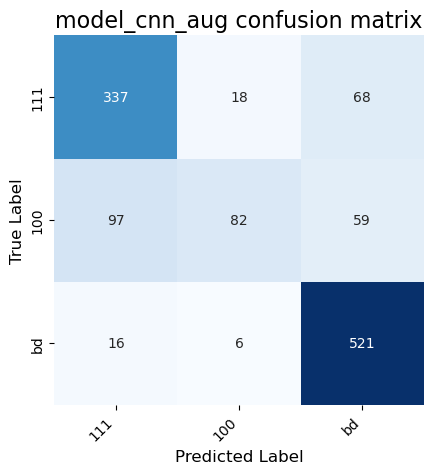

In [47]:
cm = confusion_matrix(y_true, y_pred_cnn_aug, labels=[0, 1, 2])
ax = sns.heatmap(cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False)
ax.set_title('model_cnn_aug confusion matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.savefig(os.path.join(model_folder, 'model_cnn_aug_confusionmatrix.png'), dpi=300, bbox_inches='tight')

From adding data augmentation and dropout to our CNN, the problem of overfitting during training has been mitigated, and the model performance also improved!

As with our previous models, we can zip the saved folder for easier downloading

In [48]:
!zip -r {model_folder}.zip {model_folder}

  adding: model_cnn_aug/ (164 bytes security) (stored 0%)
  adding: model_cnn_aug/assets/ (164 bytes security) (stored 0%)
  adding: model_cnn_aug/fingerprint.pb (164 bytes security) (stored 0%)
  adding: model_cnn_aug/keras_metadata.pb (164 bytes security) (deflated 93%)
  adding: model_cnn_aug/model_cnn_aug_confusionmatrix.png (164 bytes security) (deflated 17%)
  adding: model_cnn_aug/model_cnn_aug_training.png (164 bytes security) (deflated 11%)
  adding: model_cnn_aug/saved_model.pb (164 bytes security) (deflated 89%)
  adding: model_cnn_aug/variables/ (164 bytes security) (stored 0%)
  adding: model_cnn_aug/variables/variables.data-00000-of-00001 (164 bytes security) (deflated 10%)
  adding: model_cnn_aug/variables/variables.index (164 bytes security) (deflated 66%)


# Section 4: Improved defect classification with the very deep VGG16 CNN model

Here, we use the VGG16 model, which was previously trained on the very large ImageNet database (millions of images), and finetune this model using a process called transfer learning.

To run VGG16, we need to import the data in a slightly different way than before.

To process our data, we define an ImageDataGenerator to handle data augmentation, much like in Section 3. The key difference is VGG16 needs a special preprocessing of the input images so their intensities match those from the ImageNet database. In addition, we use the flow_from_directory() function instead of the flow() function, as the images will be directly read from the "all_cropped_64px" image directory we just copied.

In [49]:
batch_size = 32

train_data_dir = 'all_cropped_64px/train'

train_datagen = ImageDataGenerator(rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                              zoom_range=0.1,  # Randomly zoom image
                              width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                              height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                              horizontal_flip=True,  # randomly flip images horizontally
                              vertical_flip=False, # Don't randomly flip images vertically
                             validation_split=0.10,
                              preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input)

train_gen = train_datagen.flow_from_directory(train_data_dir,
                                               target_size=(64, 64),
                                               class_mode='categorical',
                                               classes=['100', '111', 'bd'],
                                               subset='training',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=42)

valid_gen = train_datagen.flow_from_directory(train_data_dir,
                                               target_size=(64, 64),
                                               class_mode='categorical',
                                               classes=['100', '111', 'bd'],
                                               subset='validation',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=42)


Found 10834 images belonging to 3 classes.
Found 1202 images belonging to 3 classes.


Here, we define our VGG16 model. We can control the number of layers we finetune. The layers that are not fine tuned will have their weights frozen to the values obtained from the initial training on the ImageNet database. To start, we will have the last 8 layers be trainable and the rest frozen.

In [50]:
num_layers_finetune = 8

Conv_Base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(64, 64, 3))

for layer in Conv_Base.layers[:-num_layers_finetune]:
    layer.trainable = False

for layer in Conv_Base.layers:
    print(layer, layer.trainable)

model_vgg16 = Sequential()
model_vgg16.add(Conv_Base)
model_vgg16.add(Flatten())

58889256/58889256 [==============================] - 2s 0us/step
<keras.src.engine.input_layer.InputLayer object at 0x000001C6716FEB10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001C672CB2450> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001C671766A10> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C672D96310> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001C6712C8790> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001C672D73590> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C672AD3890> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001C671806B90> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001C672A63310> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001C672CF4590> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001C672DFEBD0> False
<keras.src.layers

As in the previous sections, we add a fully connected network to classify the images based on the flattened feature vector output from VGG16:

In [51]:
model_vgg16.add(Dense(units=16, activation = 'relu'))
model_vgg16.add(Dropout(0.3))
model_vgg16.add(Dense(units=3, activation = 'softmax'))

This time, our model summary shows that the model is much larger than before, to the tune of ~13M trainable parameters, compared to the previous CNN, which had just over 70k parameters!

In [52]:
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 16)                32784     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 3)                 51        
                                                                 
Total params: 14747523 (56.26 MB)
Trainable params: 13012035 (49.64 MB)
Non-trainable params: 1735488 (6.62 MB)
_________________________________________________________________


Compared to previous models, for VGG16 we set the learning rate much lower. Too high of a learning rate can lead to the model having a very large error and it not being able to train (i.e., the error will not reduce over time)

In [53]:
model_vgg16.compile(optimizer=Adam(learning_rate=1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [54]:
model_folder = 'model_vgg16'
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=100, verbose=1, mode='max')
mcp_save = ModelCheckpoint(model_folder, restore_best_weights=True, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=50, verbose=1, min_delta=1e-4, mode='max')

The VGG16 model will take longer to train than the others considered so far. Here, we set the training to only go for 5 epochs as this will be sufficient to illustrate its performance and to keep the training time tractable, but longer training of >25 epochs is required to get higher accuracy

In [55]:
n_steps = train_gen.samples // batch_size
n_val_steps = valid_gen.samples // batch_size

history_vgg16 = model_vgg16.fit(train_gen,
          epochs=5,
          validation_data=valid_gen,
          steps_per_epoch=n_steps,
          validation_steps=n_val_steps,
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/5
338/338 [==============================] - ETA: 0s - loss: 0.6311 - accuracy: 0.5637INFO:tensorflow:Assets written to: model_vgg16\assets


INFO:tensorflow:Assets written to: model_vgg16\assets


338/338 [==============================] - 130s 380ms/step - loss: 0.6311 - accuracy: 0.5637 - val_loss: 0.4471 - val_accuracy: 0.7348 - lr: 1.0000e-05
Epoch 2/5
338/338 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.6767INFO:tensorflow:Assets written to: model_vgg16\assets


INFO:tensorflow:Assets written to: model_vgg16\assets


338/338 [==============================] - 126s 374ms/step - loss: 0.4638 - accuracy: 0.6767 - val_loss: 0.4046 - val_accuracy: 0.7542 - lr: 1.0000e-05
Epoch 3/5
338/338 [==============================] - ETA: 0s - loss: 0.4295 - accuracy: 0.7103INFO:tensorflow:Assets written to: model_vgg16\assets


INFO:tensorflow:Assets written to: model_vgg16\assets


338/338 [==============================] - 130s 384ms/step - loss: 0.4295 - accuracy: 0.7103 - val_loss: 0.3831 - val_accuracy: 0.7779 - lr: 1.0000e-05
Epoch 4/5
338/338 [==============================] - 127s 376ms/step - loss: 0.4120 - accuracy: 0.7271 - val_loss: 0.3699 - val_accuracy: 0.7779 - lr: 1.0000e-05
Epoch 5/5
338/338 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.7440INFO:tensorflow:Assets written to: model_vgg16\assets


INFO:tensorflow:Assets written to: model_vgg16\assets


338/338 [==============================] - 122s 361ms/step - loss: 0.3934 - accuracy: 0.7440 - val_loss: 0.3449 - val_accuracy: 0.7931 - lr: 1.0000e-05


After only ~5 epochs of transfer learning with VGG16, we already have a validation accuracy better than our previous CNN! From ~25 epochs, the best accuracy is about 84.5%. Further training or tuning of the fully connected network may result in even higher accuracies, but training may take several hours.

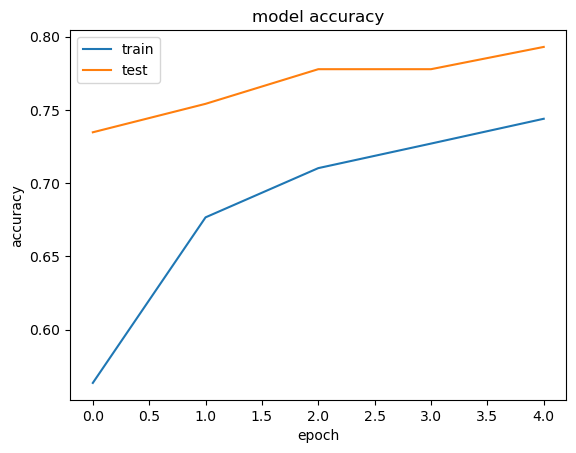

In [56]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(model_folder, 'model_vgg16_training.png'), dpi=300, bbox_inches='tight')
plt.show()

As before, we compute our key performance metrics. The accuracy is quite high, at nearly 85%. What's more, the classification F1 score is 0.8 on average, with a much improved performance on the <100> loops in particular, and very high (> 0.9) F1 on black dot defects.

In [57]:
model_vgg16_best = keras.models.load_model(model_folder)

# For test, need to turn shuffle=False
test_gen = train_datagen.flow_from_directory(train_data_dir,
                                               target_size=(64, 64),
                                               class_mode='categorical',
                                               classes=['100', '111', 'bd'],
                                               subset='validation',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=42)

y_true = test_gen.classes # The class names are in the wrong order?
vgg_preds = model_vgg16_best.predict_generator(test_gen, steps=1202)
y_pred_vgg16 = np.argmax(vgg_preds, axis=1)
model_vgg16_acc = accuracy_score(y_true, y_pred_vgg16)
print('Validation accuracy=', model_vgg16_acc)

p_r_f1 = precision_recall_fscore_support(y_true, y_pred_vgg16, labels=[0, 1, 2])
print('F1 scores:')
print('100 F1 = ', p_r_f1[2][0])
print('111 F1 = ', p_r_f1[2][1])
print('bd F1 = ', p_r_f1[2][2])
print('Average F1 score = ', np.mean([p_r_f1[2][0], p_r_f1[2][1], p_r_f1[2][2]]))


Found 1202 images belonging to 3 classes.


C:\Users\jhyan\AppData\Local\Temp\ipykernel_21704\1861479397.py:14: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  vgg_preds = model_vgg16_best.predict_generator(test_gen, steps=1202)


Validation accuracy= 0.8094841930116472
F1 scores:
100 F1 =  0.43975903614457834
111 F1 =  0.8084656084656084
bd F1 =  0.9192546583850931
Average F1 score =  0.7224931009984266


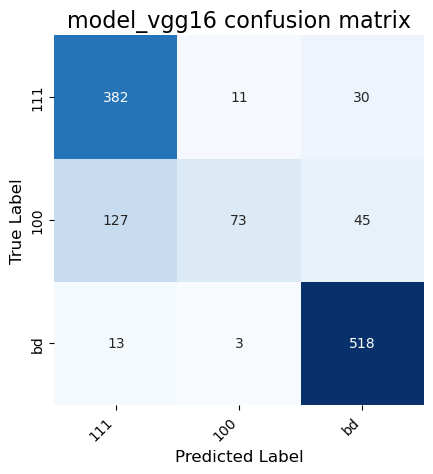

In [58]:
cm = confusion_matrix(y_true, y_pred_vgg16, labels=[1, 0, 2])
ax = sns.heatmap(cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False)
ax.set_title('model_vgg16 confusion matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.savefig(os.path.join(model_folder, 'model_vgg16_confusionmatrix.png'), dpi=300, bbox_inches='tight')

Finally, we zip up our model folder for downloading

In [59]:
!zip -r {model_folder}.zip {model_folder}

  adding: model_vgg16/ (164 bytes security) (stored 0%)
  adding: model_vgg16/assets/ (164 bytes security) (stored 0%)
  adding: model_vgg16/fingerprint.pb (164 bytes security) (stored 0%)
  adding: model_vgg16/keras_metadata.pb (164 bytes security) (deflated 96%)
  adding: model_vgg16/model_vgg16_confusionmatrix.png (164 bytes security) (deflated 18%)
  adding: model_vgg16/model_vgg16_training.png (164 bytes security) (deflated 16%)
  adding: model_vgg16/saved_model.pb (164 bytes security) (deflated 89%)
  adding: model_vgg16/variables/ (164 bytes security) (stored 0%)
  adding: model_vgg16/variables/variables.data-00000-of-00001 (164 bytes security) (deflated 7%)
  adding: model_vgg16/variables/variables.index (164 bytes security) (deflated 69%)


# Section 5: Object detection using the You Only Look Once (YOLO) model

In this section, we use the YOLO model to perform object detection on the original STEM micrograph images from which the individual defects were cropped from for our previous defect classification exercises.

First, we need to download the YOLO repository. Here, we use YOLOv5:

In [79]:
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...


There are a number of python package requirements we need to install, which we do via pip installing from the requirements.txt file:

In [73]:
#!pip install -r yolov5/requirements.txt

We need to change our working directory to be in the YOLOv5 directory we just downloaded:

In [80]:
import sys
sys.path.append('yolov5')
%cd ./yolov5
print(os.getcwd())

c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\yolov5\yolov5
c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\yolov5\yolov5


Like the case of VGG16 above, we will exploit the power of transfer learning when training YOLO. To do this, we can download the saved weights file for the so-called "medium" YOLO architecture (commented out in green). YOLO has numerous architecture sizes, e.g., nano, small, medium, large, extra large. The larger models are more accurate, but have many more trainable weights and are thus slower to train.

In the interest of time, we are going to start from a YOLO weights file that was already trained for 75 epochs, and train it for another 25 epochs before making predictions. If you want to train from scratch (though still transfer learn from the ImageNet YOLO weights), you can uncomment the green line below

In [91]:
# YOLO weights for model trained 75 epochs on our loops data
#!cp '/yolo_weights_files/best_75.pt' .
#cp yolo_weights_files/best_75.pt .

# YOLO (medium model) weights for object detection model
#!wget https://github.com/ultralytics/yolov5/releases/download/v6.2/yolov5m.pt

# YOLO (medium model) weights for instance segmentation model
#!wget https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5m-seg.pt

We need to copy the annotated data of defect loops in our microscopy images, and copy the YOLO input file, to be in the designated paths in our YOLO folder.

In [92]:
#path = './yolo_loops_data'
#!cp -r {path} .
#!mv 'yolo_loops_data' 'data'
#!mv 'data/yolo_loops_data/yolo.yaml' './data'

Let's open a random image and display the raw image to the screen:

In [94]:
#from google.colab.patches import cv2_imshow
import cv2
import pandas as pd
RESIZE_PX = 480

im_path = r'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolo_loops_data/train/images'
anno_path = r'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolo_loops_data/train/labels'
train_images = os.listdir(im_path)
train_im = np.random.choice(train_images)
im_name = train_im.split('.jpg')[0]
train_anno = os.path.join(anno_path, im_name+'.txt')
#anno = np.loadtxt(train_anno)
anno = pd.read_csv(train_anno, header=None)
im = Image.open(os.path.join(im_path, train_im)).convert('RGB')
im_resize = cv2.resize(np.array(im), (RESIZE_PX, RESIZE_PX))
#cv2_imshow(np.array(im_resize))

Now, we process the image label data so that we can plot the bounding boxes and segmentation masks on top of the raw image.

In our resulting image, blue indicates black dots, red indicates <111> loops, and yellow indicates <100> loops.

In [95]:
classes = list()
segs = list()
for i in anno.iterrows():
  classes.append(int(i[1][0][0]))
  segs.append(RESIZE_PX*np.array(i[1][0][2:].split(' '), dtype=np.float64))

In [96]:
def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)

    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]

# 0 = 100, 1= bd, 2 = 111
class_colors = {0: (0, 255, 255), 1: (0, 0, 255), 2: (255, 0, 0)}

for cls, seg in zip(classes, segs):
  seg_xy = list()
  for i, s in enumerate(seg):
    if i%2 == 0:
      seg_xy.append([int(seg[i]), int(seg[i+1])])
  bbox = bounding_box(seg_xy)
  im_resize = cv2.polylines(im_resize, [np.array(seg_xy)], isClosed=True, color=class_colors[cls])
  im_resize = cv2.rectangle(im_resize, bbox[0], bbox[1], color=class_colors[cls])
#cv2_imshow(np.array(im_resize))

We are almost ready to train our YOLO model for object detection. Here, we define the number of epochs to run for, the location of the YOLO input file, and the folder name to save output to.

Finally, we start training YOLO by calling the train.py script and pass some key parameters to this script, such as the data path, the weights file, etc.

In [105]:
EPOCHS = 5
DATA_PATH = r'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/data/yolo.yaml'
RES_DIR = r'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolov5_model'
WEIGHTS_PATH = r'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/best_75.pt' # or yolov5m.pt if starting from scratch on loops training

!python train.py --data {DATA_PATH} --weights {WEIGHTS_PATH} --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} --patience 0

# segmentation done through segment/train.py and yolov5m-seg.pt weights file
#!python segment/train.py --data {DATA_PATH} --weights yolov5m-seg.pt --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} --patience 0


train: weights=c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/best_75.pt, cfg=, data=c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/data/yolo.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolov5_model, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=0, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-350-g6096750f Python-3.1

Now that we have our trained YOLO model, we can run inference on our validation data set using YOLOv5's val.py script. Doing this will give us precision, recall, and mean average precision at IoU=0.5 for each defect type and for all types combined.

The results will be saved in the **yolov5/runs/val** folder. In that folder, there are other analyses, such as precision-recall curve, F1-confidence curve, etc.

In [111]:
WEIGHTS_PATH = 'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolov5_model7/weights/best.pt'

!python val.py --weights {WEIGHTS_PATH} --data {DATA_PATH} --max-det=1000

val: data=c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/data/yolo.yaml, weights=['c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolov5_model7/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=1000, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-350-g6096750f Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs

val: Scanning C:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\data\yolo_loops_data\valid\labels...:   0%|          | 0/22 [00:00<?, ?it/s]
val: Scanning C:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\data\yolo_loops_data\valid\labels... 1 images, 0 ba

In addition to obtaining statistical measures of our model performance, it is helpful to visually see what features of the images the model detects as defects. We can do this with YOLOv5's detect.py script. The results will be saved in the **yolov5/runs/detect/** folder.

Each validation image will have the predicted bounding boxes and class label overlaid.



In [114]:
VAL_IM = 'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/data/yolo_loops_data/valid/images'
WEIGHTS_PATH = 'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolov5_model7/weights/best.pt'

!python detect.py --weights {WEIGHTS_PATH} --source {VAL_IM}

detect: weights=['c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolov5_model7/weights/best.pt'], source=c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/data/yolo_loops_data/valid/images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v7.0-350-g6096750f Python-3.11.5 torch-2.1.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 8192MiB)

Fusing layers... 
Model summary: 212 layers, 20861016 parameters, 0 gradients, 47.9 GFLOPs
image 1/22 C:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\data\yolo_loops_data\valid\images\0501_300kx_1nm_clhaadf3_0006.jpg: 

Finally, we can make some qualitative assessments by inspecting the image with YOLO predictions vs. the raw image with the ground truth labels overlaid. We can clearly see some instances of correct predictions at the right location, false negatives and false positives in the form of mis-classification.

In [119]:
from copy import copy
im_val_name = '0501_300kx_1nm_clhaadf3_0008.jpg'

im_val_path = 'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/yolov5/runs/detect/exp3/'+im_val_name
im_val_raw_path = 'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/data/yolo_loops_data/valid/images/'+im_val_name
anno_val_path = 'c:/Users/jhyan/Documents/all/UW-Madison/course_enroll/MSE_401/Module_5/data/yolo_loops_data/valid/labels/'+im_val_name.split('.jpg')[0]+'.txt'
im_val = Image.open(im_val_path).convert('RGB')
im_val_resize = cv2.resize(np.array(im_val), (RESIZE_PX, RESIZE_PX))
im_val_raw = Image.open(im_val_raw_path).convert('RGB')
im_val_raw_resize = cv2.resize(np.array(im_val_raw), (RESIZE_PX, RESIZE_PX))

print('PREDICTED')
#cv2_imshow(np.array(im_val_resize))

anno = pd.read_csv(anno_val_path, header=None)
classes = list()
segs = list()
for i in anno.iterrows():
  classes.append(int(i[1][0][0]))
  segs.append(RESIZE_PX*np.array(i[1][0][2:].split(' '), dtype=np.float64))
for cls, seg in zip(classes, segs):
  seg_xy = list()
  for i, s in enumerate(seg):
    if i%2 == 0:
      seg_xy.append([int(seg[i]), int(seg[i+1])])
  bbox = bounding_box(seg_xy)
  im_val_raw_resize = cv2.polylines(im_val_raw_resize, [np.array(seg_xy)], isClosed=True, color=class_colors[cls])
  im_val_raw_resize = cv2.rectangle(im_val_raw_resize, bbox[0], bbox[1], color=class_colors[cls])

print('GROUND TRUTH')
#cv2_imshow(np.array(im_val_raw_resize))

PREDICTED
GROUND TRUTH


# Exercise 1: Revisit adding layers to our FCN



**Goal:**  
Examine the claim from section 1 that adding more layers to our Fully Connected Network from Section 1 will not significantly improve performance.

**Instructions:**  
1) run the code blocks below to initialize a similar FCN network to what we ran in section1  
2) Edit the code block "Edit Below Here" section to modify the number of fully connected layers  
3) train and assess the performance of the model and report out to the group (via Zoom chat)  

In [121]:
#%cd /content

In [122]:
X_train, X_val, y_train, y_val = train_test_split(images_all, y_all, shuffle='True', random_state=42, test_size=0.1)

In [123]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(10832, 4096) (1204, 4096) (10832, 3) (1204, 3)


In [124]:
ex1_model_dense = Sequential()

---
## Edit Here

In [133]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(images_all, y_all, shuffle=True, random_state=42, test_size=0.1)

# Print dataset shapes
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# Create the model
ex1_model_dense = Sequential()

# Add fully connected layers
ex1_model_dense.add(Dense(units=16, activation='relu', input_shape=(4096,)))
# Add more fully connected layers as needed
ex1_model_dense.add(Dense(units=16, activation='relu'))
# Additional fully connected layers
ex1_model_dense.add(Dense(units=32, activation='relu'))

# Add the output layer
ex1_model_dense.add(Dense(units=3, activation='softmax'))

# Compile the model
ex1_model_dense.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up model saving path and callbacks
model_folder = './model_dense_modified'
os.makedirs(model_folder, exist_ok=True)
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
mcp_save = ModelCheckpoint(os.path.join(model_folder, 'best_model.h5'), save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')

# Train the model
history_dense = ex1_model_dense.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), 
                                   callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

(10832, 4096) (1204, 4096) (10832, 3) (1204, 3)
Epoch 1/50
339/339 [==============================] - 1s 2ms/step - loss: 0.8916 - accuracy: 0.6031 - val_loss: 0.9028 - val_accuracy: 0.5897 - lr: 0.0010
Epoch 2/50
114/339 [=========>....................] - ETA: 0s - loss: 0.7907 - accuracy: 0.6664

C:\Users\jhyan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


339/339 [==============================] - 1s 2ms/step - loss: 0.7816 - accuracy: 0.6713 - val_loss: 0.7689 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 3/50
339/339 [==============================] - 1s 2ms/step - loss: 0.7685 - accuracy: 0.6727 - val_loss: 0.7382 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 4/50
339/339 [==============================] - 1s 2ms/step - loss: 0.7402 - accuracy: 0.6833 - val_loss: 0.7416 - val_accuracy: 0.6819 - lr: 0.0010
Epoch 5/50
339/339 [==============================] - 1s 2ms/step - loss: 0.7433 - accuracy: 0.6777 - val_loss: 0.7739 - val_accuracy: 0.6661 - lr: 0.0010
Epoch 6/50
339/339 [==============================] - 1s 2ms/step - loss: 0.7267 - accuracy: 0.6862 - val_loss: 0.7088 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 7/50
339/339 [==============================] - 1s 2ms/step - loss: 0.7236 - accuracy: 0.6855 - val_loss: 0.7114 - val_accuracy: 0.6977 - lr: 0.0010
Epoch 8/50
339/339 [==============================] - 1s 2ms/step - loss: 0.7178 

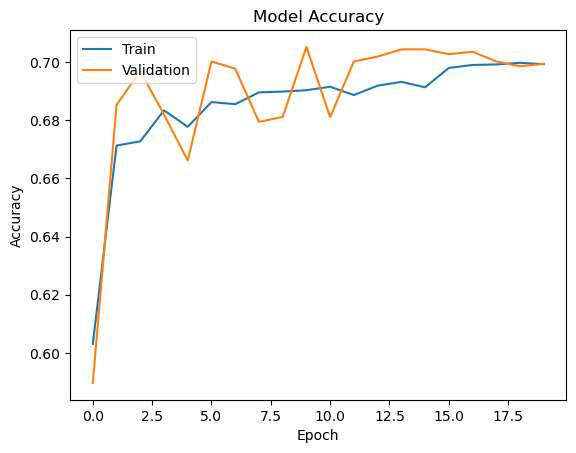

In [134]:
# Plot accuracy
plt.plot(history_dense.history['accuracy'])
plt.plot(history_dense.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(os.path.join(model_folder, 'training_accuracy.png'), dpi=300, bbox_inches='tight')
plt.show()

In [135]:
# Evaluate the model
model_dense_best = keras.models.load_model(os.path.join(model_folder, 'best_model.h5'))

preds = model_dense_best.predict(X_val)
y_true = np.argmax(y_val, axis=1)
y_pred_dense = np.argmax(preds, axis=1)
model_dense_acc = accuracy_score(y_true, y_pred_dense)
print('Validation Accuracy:', model_dense_acc)

38/38 [==============================] - 0s 1ms/step
Validation Accuracy: 0.7051495016611296


In [136]:
# Calculate and print F1 scores
p_r_f1 = precision_recall_fscore_support(y_true, y_pred_dense, labels=[0, 1, 2])
print('F1 Scores:')
print('Class 0 F1:', p_r_f1[2][0])
print('Class 1 F1:', p_r_f1[2][1])
print('Class 2 F1:', p_r_f1[2][2])
print('Average F1 Score:', np.mean(p_r_f1[2]))

F1 Scores:
Class 0 F1: 0.7206208425720622
Class 1 F1: 0.0
Class 2 F1: 0.8264984227129336
Average F1 Score: 0.5157064217616653


C:\Users\jhyan\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


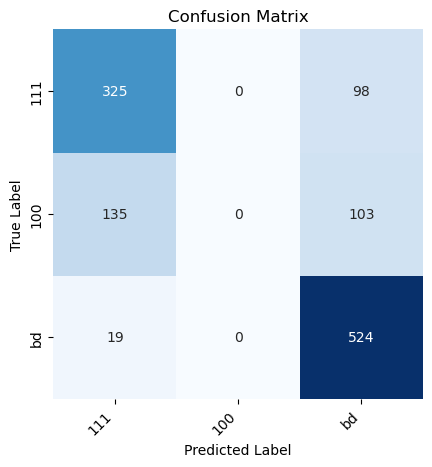

In [137]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred_dense, labels=[0, 1, 2])
ax = sns.heatmap(cm, annot=True, square=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap=plt.cm.Blues, cbar=False)
ax.set_title('Confusion Matrix')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')
plt.savefig(os.path.join(model_folder, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')

In [138]:
# Compress and save the model files
!zip -r {model_folder}.zip {model_folder}

updating: model_dense_modified/ (164 bytes security) (stored 0%)
updating: model_dense_modified/best_model.h5 (164 bytes security) (deflated 18%)
updating: model_dense_modified/confusion_matrix.png (164 bytes security) (deflated 19%)
updating: model_dense_modified/training_accuracy.png (164 bytes security) (deflated 12%)


Add additional lines identical to the 2 below to add more layers to your fully connected network (FCN). Based on our previous tests we wouldn't recommend adding more than ~20 or so layers unless you want to see things start to break down during the training process.

Note: if you rerun this code block multiple times below layers will continue to be added to the network. Make sure to double check with the summary to confirm the number of layers is what you intended.

In [139]:
ex1_model_dense.add(Dense(units=16, activation='relu', input_shape=(4096,)))

End of edits

---

In [140]:
ex1_model_dense.add(Dense(units=3, activation='softmax'))

In [141]:
ex1_model_dense.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 16)                65552     
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                                 
 dense_16 (Dense)            (None, 3)                 99        
                                                                 
 dense_17 (Dense)            (None, 16)                64        
                                                                 
 dense_18 (Dense)            (None, 3)                 51        
                                                                 
Total params: 66582 (260.09 KB)
Trainable params: 6658

In [142]:
ex1_model_dense.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [143]:
ex1_model_folder = 'ex1_model_dense'
ex1_earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
ex1_mcp_save = ModelCheckpoint(os.path.join(dirpath, ex1_model_folder), restore_best_weights=True, save_best_only=True, monitor='val_accuracy', mode='max')
ex1_reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')

In [144]:
ex1_history_dense = ex1_model_dense.fit(X_train,
                                y_train,
                                epochs=50,
                                verbose=1,
                                steps_per_epoch=len(X_train)/32, # Run same number of steps we would if we were not using a generator.
                                validation_data=(X_val, y_val),
                                callbacks=[ex1_earlyStopping, ex1_mcp_save, ex1_reduce_lr_loss])

Epoch 1/50
333/338 [============================>.] - ETA: 0s - loss: 0.8450 - accuracy: 0.6536INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


338/338 [==============================] - 2s 4ms/step - loss: 0.8438 - accuracy: 0.6542 - val_loss: 0.8604 - val_accuracy: 0.6470 - lr: 0.0010
Epoch 2/50
331/338 [============================>.] - ETA: 0s - loss: 0.7434 - accuracy: 0.6845INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


338/338 [==============================] - 1s 3ms/step - loss: 0.7431 - accuracy: 0.6850 - val_loss: 0.7211 - val_accuracy: 0.6968 - lr: 0.0010
Epoch 3/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7250 - accuracy: 0.6867 - val_loss: 0.7177 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 4/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7116 - accuracy: 0.6923 - val_loss: 0.7177 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 5/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7168 - accuracy: 0.6898 - val_loss: 0.7198 - val_accuracy: 0.6902 - lr: 0.0010
Epoch 6/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7139 - accuracy: 0.6907 - val_loss: 0.7373 - val_accuracy: 0.6960 - lr: 0.0010
Epoch 7/50
310/338 [==========================>...] - ETA: 0s - loss: 0.7061 - accuracy: 0.6928INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


338/338 [==============================] - 2s 5ms/step - loss: 0.7057 - accuracy: 0.6917 - val_loss: 0.7139 - val_accuracy: 0.7018 - lr: 0.0010
Epoch 8/50
323/338 [===========================>..] - ETA: 0s - loss: 0.7061 - accuracy: 0.6920INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


338/338 [==============================] - 1s 4ms/step - loss: 0.7034 - accuracy: 0.6930 - val_loss: 0.7013 - val_accuracy: 0.7085 - lr: 0.0010
Epoch 9/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7095 - accuracy: 0.6945 - val_loss: 0.7152 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 10/50
338/338 [==============================] - 1s 2ms/step - loss: 0.7011 - accuracy: 0.6950 - val_loss: 0.7006 - val_accuracy: 0.7076 - lr: 0.0010
Epoch 11/50
338/338 [==============================] - 1s 2ms/step - loss: 0.6991 - accuracy: 0.6983 - val_loss: 0.7053 - val_accuracy: 0.7018 - lr: 0.0010
Epoch 12/50
338/338 [==============================] - 1s 2ms/step - loss: 0.6972 - accuracy: 0.6956 - val_loss: 0.7495 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 13/50
325/338 [===========================>..] - ETA: 0s - loss: 0.7029 - accuracy: 0.6917
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
338/338 [==============================] - 1s 2ms/step - l

INFO:tensorflow:Assets written to: c:\Users\jhyan\Documents\all\UW-Madison\course_enroll\MSE_401\Module_5\ex1_model_dense\assets


338/338 [==============================] - 1s 4ms/step - loss: 0.6810 - accuracy: 0.7021 - val_loss: 0.6955 - val_accuracy: 0.7093 - lr: 1.0000e-04
Epoch 17/50
338/338 [==============================] - 1s 2ms/step - loss: 0.6809 - accuracy: 0.7021 - val_loss: 0.6941 - val_accuracy: 0.7002 - lr: 1.0000e-04
Epoch 18/50
338/338 [==============================] - 1s 2ms/step - loss: 0.6807 - accuracy: 0.7035 - val_loss: 0.6931 - val_accuracy: 0.7060 - lr: 1.0000e-04
Epoch 19/50
338/338 [==============================] - 1s 2ms/step - loss: 0.6793 - accuracy: 0.7042 - val_loss: 0.6925 - val_accuracy: 0.7043 - lr: 1.0000e-04
Epoch 20/50
338/338 [==============================] - 1s 2ms/step - loss: 0.6794 - accuracy: 0.7037 - val_loss: 0.6967 - val_accuracy: 0.7043 - lr: 1.0000e-04
Epoch 21/50
326/338 [===========================>..] - ETA: 0s - loss: 0.6784 - accuracy: 0.7044
Epoch 21: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
338/338 [============================

## Training Plotting

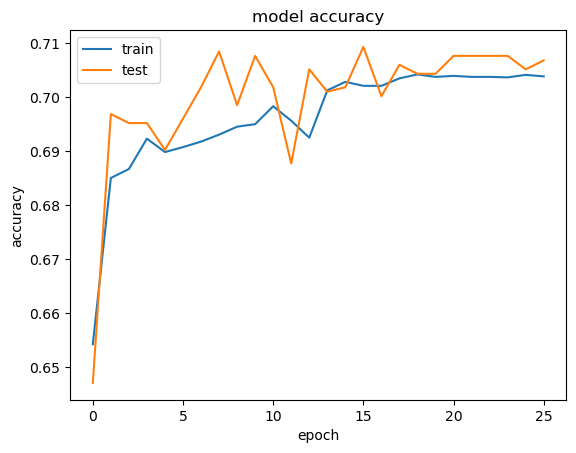

In [146]:
plt.plot(ex1_history_dense.history['accuracy'])
plt.plot(ex1_history_dense.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig(os.path.join(ex1_model_folder, 'model_dense_training.png'), dpi=300, bbox_inches='tight')
plt.show()

## Quantitative Report



In [148]:
#model_dense_best = keras.models.load_model(ex1_model_folder)

preds = model_dense_best.predict(X_val)
y_true = np.argmax(y_val, axis=1)
y_pred_dense = np.argmax(preds, axis=1)
model_dense_acc = accuracy_score(y_true, y_pred_dense)
print('Validation accuracy=', model_dense_acc)

p_r_f1 = precision_recall_fscore_support(y_true, y_pred_dense, labels=[0, 1, 2])
print('F1 scores:')
print('111 F1 = ', p_r_f1[2][0])
print('100 F1 = ', p_r_f1[2][1])
print('bd F1 = ', p_r_f1[2][2])
print('Average F1 score = ', np.mean([p_r_f1[2][0], p_r_f1[2][1], p_r_f1[2][2]]))

38/38 [==============================] - 0s 993us/step
Validation accuracy= 0.7051495016611296
F1 scores:
111 F1 =  0.7206208425720622
100 F1 =  0.0
bd F1 =  0.8264984227129336
Average F1 score =  0.5157064217616653


C:\Users\jhyan\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

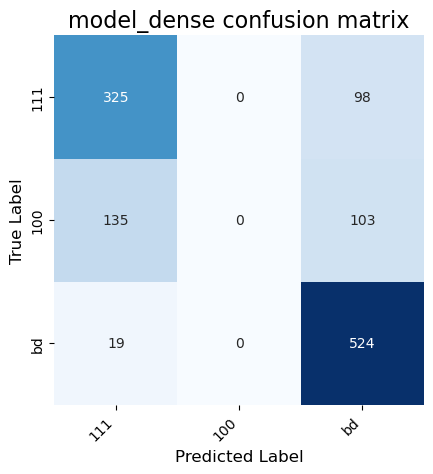

In [149]:
cm = confusion_matrix(y_true, y_pred_dense, labels=[0, 1, 2])
ax = sns.heatmap(cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False)
ax.set_title('model_dense confusion matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.savefig(os.path.join(model_folder, 'model_dense_confusionmatrix.png'), dpi=300, bbox_inches='tight')

## Report out to the Group

Report out via Zoom chat the Following:

1) Number of fully connect layers in your model. (This is the number of lines you added in the edit section above)  
2) The Validation Accuracy of your best model. This is the "validation accuracy" from the quantitative report above.  
3) Qualitatively, did your model predict any 100 type defects? You can see this in the confusion matrix above. Did the model predict anything in the second column?

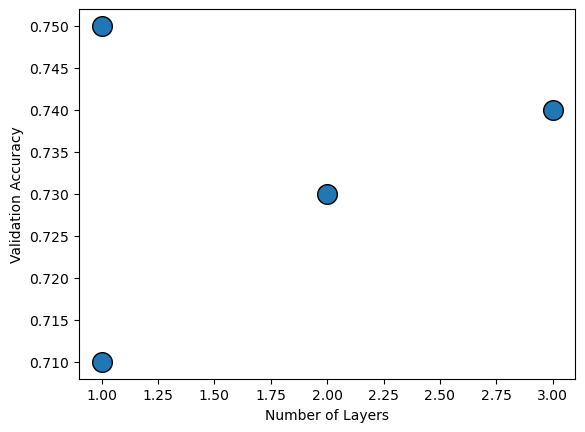

In [150]:
Group_Reported_Accuracies = [0.71,0.73,0.74,0.75]
Group_Reported_Num_Layers = [1,2,3,1]

plt.scatter(Group_Reported_Num_Layers, Group_Reported_Accuracies,s=200,edgecolor='k')
plt.xlabel("Number of Layers")
plt.ylabel("Validation Accuracy")
plt.show()

# Exercise 2: Modifying Convolution Layers

**Goal:**  
Examine the sensitivity of the convolution structure to modifications

**Instructions:**  
1) run the code blocks below to initialize a similar CNN to what we used in section 2  
2) Edit the code block "Edit Below Here" section to modify the number of convolution layers, either adding or removing a layer   
3) train and assess the performance of the model and report out to the group (via Zoom chat)  

In [151]:
#%cd /content

In [153]:
X_train, X_val, y_train, y_val = train_test_split(images_all, y_all, shuffle='True', random_state=42, test_size=0.1)
X_train = X_train.reshape(-1, 64, 64, 1)
X_val = X_val.reshape(-1, 64, 64, 1)

In [154]:
ex2_model_cnn = Sequential()

ex2_model_cnn.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(64, 64, 1)))
ex2_model_cnn.add(BatchNormalization())
ex2_model_cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))

ex2_model_cnn.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
ex2_model_cnn.add(Dropout(0.2))
ex2_model_cnn.add(BatchNormalization())
ex2_model_cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))

---
## Edit Here

Either copy the three lines below to add a convolution layer to your network or comment out the three lines to skip adding in this last convolution layer.

If you choose to add in a convolution layer also update the first input to Conv2D(). You can either make it smaller to follow the trend established in the previous layers where the output continuously shrinks, make is the same to maintain the size, or you could even make it bigger to increase the output size.

The batch normalization and MaxPool2D lines you can leave the same.

In [155]:
ex2_model_cnn.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
ex2_model_cnn.add(BatchNormalization())
ex2_model_cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))

In [156]:
# copy the three lines above here to add an additional convolution layer
ex2_model_cnn.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
ex2_model_cnn.add(BatchNormalization())
ex2_model_cnn.add(MaxPool2D((2, 2), strides=2, padding="same"))

alternative ideas for modifications to try in the future:
- Remove the batch normaliation and maxp pooling layers to see their effects
- Adjust the stride of the various layers
- adjust the kernel size (second input for the conv2d layer)

---

In [157]:
ex2_model_cnn.add(Flatten())

ex2_model_cnn.add(Dense(units=16, activation="relu"))
ex2_model_cnn.add(Dense(units=3, activation="softmax"))

In [158]:
ex2_model_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 75)        750       
                                                                 
 batch_normalization_6 (Bat  (None, 64, 64, 75)        300       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 75)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 50)        33800     
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 50)        0         
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 50)       

In [159]:
ex2_model_cnn.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [160]:
ex2_model_folder = 'ex2_model_cnn'
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
mcp_save = ModelCheckpoint(ex2_model_folder, restore_best_weights=True, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')

In [161]:
ex2_history_cnn = ex2_model_cnn.fit(X_train,
                            y_train,
                            epochs=100,
                            verbose=1,
                            steps_per_epoch=len(X_train)/32, # Run same number of steps we would if we were not using a generator.
                            validation_data=(X_val, y_val),
                            callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/100
338/338 [============================>.] - ETA: 0s - loss: 0.7312 - accuracy: 0.6945INFO:tensorflow:Assets written to: ex2_model_cnn\assets


INFO:tensorflow:Assets written to: ex2_model_cnn\assets


338/338 [==============================] - 33s 94ms/step - loss: 0.7309 - accuracy: 0.6946 - val_loss: 1.0547 - val_accuracy: 0.3937 - lr: 0.0010
Epoch 2/100
338/338 [============================>.] - ETA: 0s - loss: 0.6112 - accuracy: 0.7488INFO:tensorflow:Assets written to: ex2_model_cnn\assets


INFO:tensorflow:Assets written to: ex2_model_cnn\assets


338/338 [==============================] - 29s 87ms/step - loss: 0.6114 - accuracy: 0.7484 - val_loss: 0.7226 - val_accuracy: 0.6694 - lr: 0.0010
Epoch 3/100
338/338 [============================>.] - ETA: 0s - loss: 0.5742 - accuracy: 0.7666INFO:tensorflow:Assets written to: ex2_model_cnn\assets


INFO:tensorflow:Assets written to: ex2_model_cnn\assets


338/338 [==============================] - 29s 85ms/step - loss: 0.5741 - accuracy: 0.7665 - val_loss: 0.6884 - val_accuracy: 0.6985 - lr: 0.0010
Epoch 4/100
338/338 [==============================] - 29s 85ms/step - loss: 0.5468 - accuracy: 0.7745 - val_loss: 0.8278 - val_accuracy: 0.6719 - lr: 0.0010
Epoch 5/100
338/338 [==============================] - 29s 86ms/step - loss: 0.5197 - accuracy: 0.7898 - val_loss: 0.7783 - val_accuracy: 0.6453 - lr: 0.0010
Epoch 6/100
338/338 [==============================] - 29s 86ms/step - loss: 0.4941 - accuracy: 0.7993 - val_loss: 0.7867 - val_accuracy: 0.6869 - lr: 0.0010
Epoch 7/100
338/338 [==============================] - 29s 85ms/step - loss: 0.4804 - accuracy: 0.8084 - val_loss: 0.9658 - val_accuracy: 0.6221 - lr: 0.0010
Epoch 8/100
338/338 [============================>.] - ETA: 0s - loss: 0.4574 - accuracy: 0.8158
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
338/338 [==============================] - 28s 8

INFO:tensorflow:Assets written to: ex2_model_cnn\assets


338/338 [==============================] - 28s 84ms/step - loss: 0.4006 - accuracy: 0.8410 - val_loss: 0.6066 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 10/100
338/338 [============================>.] - ETA: 0s - loss: 0.3858 - accuracy: 0.8493INFO:tensorflow:Assets written to: ex2_model_cnn\assets


INFO:tensorflow:Assets written to: ex2_model_cnn\assets


338/338 [==============================] - 30s 87ms/step - loss: 0.3855 - accuracy: 0.8494 - val_loss: 0.5631 - val_accuracy: 0.7757 - lr: 1.0000e-04
Epoch 11/100
338/338 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.8510INFO:tensorflow:Assets written to: ex2_model_cnn\assets


INFO:tensorflow:Assets written to: ex2_model_cnn\assets


338/338 [==============================] - 29s 86ms/step - loss: 0.3753 - accuracy: 0.8508 - val_loss: 0.5688 - val_accuracy: 0.7774 - lr: 1.0000e-04
Epoch 12/100
338/338 [==============================] - 28s 83ms/step - loss: 0.3669 - accuracy: 0.8580 - val_loss: 0.5685 - val_accuracy: 0.7774 - lr: 1.0000e-04
Epoch 13/100
338/338 [==============================] - 28s 82ms/step - loss: 0.3606 - accuracy: 0.8600 - val_loss: 0.7094 - val_accuracy: 0.7159 - lr: 1.0000e-04
Epoch 14/100
339/338 [==============================] - ETA: 0s - loss: 0.3558 - accuracy: 0.8580INFO:tensorflow:Assets written to: ex2_model_cnn\assets


INFO:tensorflow:Assets written to: ex2_model_cnn\assets


338/338 [==============================] - 30s 87ms/step - loss: 0.3558 - accuracy: 0.8580 - val_loss: 0.5549 - val_accuracy: 0.7915 - lr: 1.0000e-04
Epoch 15/100
338/338 [==============================] - 27s 81ms/step - loss: 0.3490 - accuracy: 0.8641 - val_loss: 0.6171 - val_accuracy: 0.7633 - lr: 1.0000e-04
Epoch 16/100
338/338 [==============================] - 27s 80ms/step - loss: 0.3435 - accuracy: 0.8672 - val_loss: 0.5746 - val_accuracy: 0.7799 - lr: 1.0000e-04
Epoch 17/100
338/338 [==============================] - 27s 81ms/step - loss: 0.3382 - accuracy: 0.8668 - val_loss: 0.5969 - val_accuracy: 0.7691 - lr: 1.0000e-04
Epoch 18/100
338/338 [==============================] - 27s 80ms/step - loss: 0.3305 - accuracy: 0.8711 - val_loss: 0.5581 - val_accuracy: 0.7832 - lr: 1.0000e-04
Epoch 19/100
338/338 [============================>.] - ETA: 0s - loss: 0.3272 - accuracy: 0.8719
Epoch 19: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
338/338 [=============

## Training Plotting

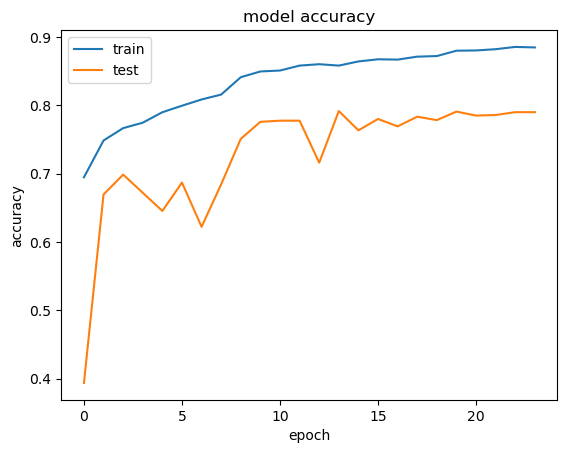

In [162]:
plt.plot(ex2_history_cnn.history['accuracy'])
plt.plot(ex2_history_cnn.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(ex2_model_folder, 'model_cnn_training.png'), dpi=300, bbox_inches='tight')
plt.show()

## Quantitative Report

In [163]:
model_cnn_best = keras.models.load_model(ex2_model_folder)

preds = model_cnn_best.predict(X_val)
y_true = np.argmax(y_val, axis=1)
y_pred_cnn = np.argmax(preds, axis=1)
model_cnn_acc = accuracy_score(y_true, y_pred_cnn)
print('Validation accuracy=', model_cnn_acc)

p_r_f1 = precision_recall_fscore_support(y_true, y_pred_cnn, labels=[0, 1, 2])
print('F1 scores:')
print('111 F1 = ', p_r_f1[2][0])
print('100 F1 = ', p_r_f1[2][1])
print('bd F1 = ', p_r_f1[2][2])
print('Average F1 score = ', np.mean([p_r_f1[2][0], p_r_f1[2][1], p_r_f1[2][2]]))

38/38 [==============================] - 1s 24ms/step
Validation accuracy= 0.7915282392026578
F1 scores:
111 F1 =  0.7710011507479861
100 F1 =  0.5808080808080808
bd F1 =  0.8801399825021873
Average F1 score =  0.7439830713527514


## Confusion Matrix

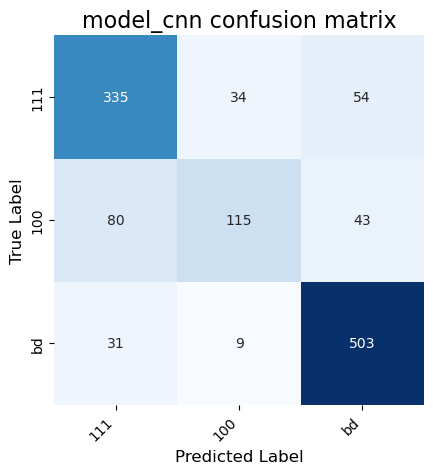

In [164]:
cm = confusion_matrix(y_true, y_pred_cnn, labels=[0, 1, 2])
ax = sns.heatmap(cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False)
ax.set_title('model_cnn confusion matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.savefig(os.path.join(ex2_model_folder, 'model_cnn_confusionmatrix.png'), dpi=300, bbox_inches='tight')

## Report out to the Group

Report out via Zoom chat the Following:

1) Modification to the number of Convolution layers, did you add or remove one? if you added one what was the output size of the convolution layer (the first input in the conv2d call)?   
2) The Validation Accuracy of your new model. This is the "validation accuacry" from the quantitative report above.  
3) Qualitatively, did your model predict any 100 type defects? You can see this in the confusion matrix above. Did the model predict anything in the second column?

# Exercise 3: Variability in Training from Scratch

**Goal:**  
Assemble an approximate distribution of variability in training networks from random starting conditions

**Instructions:**  
1) Copy your results from Section 3 and assemble with the rest of the group  
2) (optional) assemble results from other group members and plot below. Alternatively if running solo you can rerun section 3 multiple times to get a similar distribution of results.

Report out via Zoom chat the Following:

1) The Validation Accuracy of your best model from section 3. This is the "validation accuracy" from the quantitative report above.  

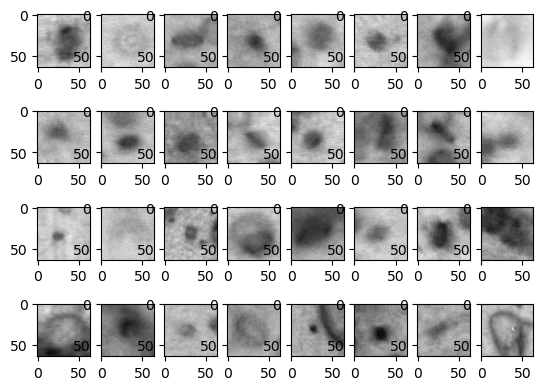

In [165]:
datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
)

batch_size = 32
img_iter = datagen.flow(X_train, y_train, batch_size=batch_size)
datagen.fit(X_train)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image), cmap='gray', vmin=0, vmax=1)
plt.show()

In [166]:

model_cnn_aug = Sequential()
'''
model_cnn_aug.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu",
                 input_shape=(64, 64, 1)))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn_aug.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model_cnn_aug.add(Dropout(0.2))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn_aug.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn_aug.add(Flatten())

model_cnn_aug.add(Dense(units=16, activation="relu"))
model_cnn_aug.add(Dropout(0.3))
model_cnn_aug.add(Dense(units=3, activation="softmax"))
'''

# Convolutional layer 1: Increase number of filters and use a larger kernel size
model_cnn_aug.add(Conv2D(64, (5, 5), strides=1, padding="same", activation="relu", input_shape=(64, 64, 1)))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

# Convolutional layer 2: Increase number of filters and add Dropout
model_cnn_aug.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
model_cnn_aug.add(Dropout(0.3))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

# Convolutional layer 3: Add another convolutional layer with a different number of filters
model_cnn_aug.add(Conv2D(256, (3, 3), strides=1, padding="same", activation="relu"))
model_cnn_aug.add(BatchNormalization())
model_cnn_aug.add(MaxPool2D((2, 2), strides=2, padding="same"))

model_cnn_aug.add(Flatten())

# Fully connected (dense) layers
model_cnn_aug.add(Dense(units=64, activation="relu"))  # Increased units for more capacity
model_cnn_aug.add(Dropout(0.4))  # Increased dropout rate to prevent overfitting
model_cnn_aug.add(Dense(units=3, activation="softmax"))

model_cnn_aug.summary()

model_cnn_aug.compile(optimizer=Adam(learning_rate=1e-2), loss="categorical_crossentropy", metrics=["accuracy"])

model_folder = 'model_cnn_aug'
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
mcp_save = ModelCheckpoint(model_folder, restore_best_weights=True, save_best_only=True, monitor='val_accuracy', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='max')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        1664      
                                                                 
 batch_normalization_10 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 batch_normalization_11 (Ba  (None, 32, 32, 128)      

In [167]:
history_cnn_aug = model_cnn_aug.fit(img_iter,
          epochs=30,
          steps_per_epoch=len(X_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(X_val, y_val),
          callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/30
339/338 [==============================] - ETA: 0s - loss: 2.3972 - accuracy: 0.4778INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 48s 137ms/step - loss: 2.3972 - accuracy: 0.4778 - val_loss: 6.4591 - val_accuracy: 0.3912 - lr: 0.0100
Epoch 2/30
339/338 [==============================] - ETA: 0s - loss: 1.0543 - accuracy: 0.4441INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 46s 136ms/step - loss: 1.0543 - accuracy: 0.4441 - val_loss: 1.0412 - val_accuracy: 0.4493 - lr: 0.0100
Epoch 3/30
339/338 [==============================] - ETA: 0s - loss: 1.0532 - accuracy: 0.4437INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 45s 134ms/step - loss: 1.0532 - accuracy: 0.4437 - val_loss: 1.0376 - val_accuracy: 0.4510 - lr: 0.0100
Epoch 4/30
339/338 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.4438INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 46s 135ms/step - loss: 1.0534 - accuracy: 0.4438 - val_loss: 1.0369 - val_accuracy: 0.4518 - lr: 0.0100
Epoch 5/30
338/338 [==============================] - 45s 131ms/step - loss: 1.0529 - accuracy: 0.4438 - val_loss: 1.0368 - val_accuracy: 0.4518 - lr: 0.0100
Epoch 6/30
338/338 [==============================] - 44s 131ms/step - loss: 1.0537 - accuracy: 0.4438 - val_loss: 3.3309 - val_accuracy: 0.3804 - lr: 0.0100
Epoch 7/30
339/338 [==============================] - ETA: 0s - loss: 1.0701 - accuracy: 0.4441INFO:tensorflow:Assets written to: model_cnn_aug\assets


INFO:tensorflow:Assets written to: model_cnn_aug\assets


338/338 [==============================] - 44s 130ms/step - loss: 1.0701 - accuracy: 0.4441 - val_loss: 1.0488 - val_accuracy: 0.4527 - lr: 0.0100
Epoch 8/30
338/338 [==============================] - 44s 131ms/step - loss: 1.0535 - accuracy: 0.4437 - val_loss: 1.0481 - val_accuracy: 0.4510 - lr: 0.0100
Epoch 9/30
338/338 [==============================] - 45s 132ms/step - loss: 1.0532 - accuracy: 0.4437 - val_loss: 1.0487 - val_accuracy: 0.4510 - lr: 0.0100
Epoch 10/30
338/338 [==============================] - 44s 129ms/step - loss: 1.0537 - accuracy: 0.4445 - val_loss: 1.0476 - val_accuracy: 0.4510 - lr: 0.0100
Epoch 11/30
338/338 [==============================] - 45s 132ms/step - loss: 1.0535 - accuracy: 0.4437 - val_loss: 1.0479 - val_accuracy: 0.4510 - lr: 0.0100
Epoch 12/30
339/338 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.4437
Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
338/338 [==============================] - 44

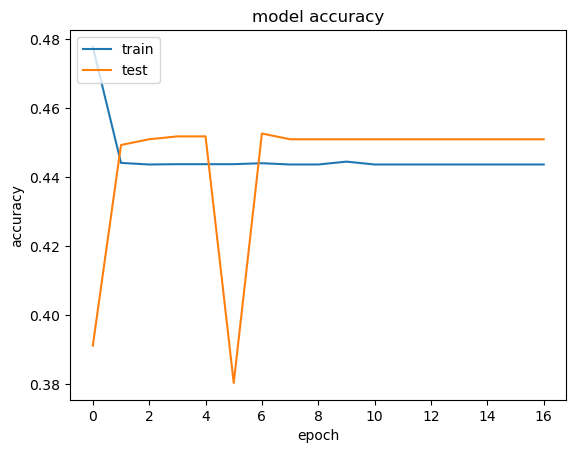

In [168]:
plt.plot(history_cnn_aug.history['accuracy'])
plt.plot(history_cnn_aug.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(os.path.join(model_folder, 'model_cnn_aug_training.png'), dpi=300, bbox_inches='tight')
plt.show()

In [169]:
# Load the best saved model and compute the validation accuracy
model_cnn_aug_best = keras.models.load_model(os.path.join(dirpath, 'model_cnn_aug'))

preds = model_cnn_aug_best.predict(X_val)
y_true = np.argmax(y_val, axis=1)
y_pred_cnn_aug = np.argmax(preds, axis=1)
model_cnn_aug_acc = accuracy_score(y_true, y_pred_cnn_aug)
print('Validation accuracy=', model_cnn_aug_acc)

38/38 [==============================] - 1s 21ms/step
Validation accuracy= 0.7807308970099668


In [170]:
p_r_f1 = precision_recall_fscore_support(y_true, y_pred_cnn_aug, labels=[0, 1, 2])
print('F1 scores:')
print('111 F1 = ', p_r_f1[2][0])
print('100 F1 = ', p_r_f1[2][1])
print('bd F1 = ', p_r_f1[2][2])
print('Average F1 score = ', np.mean([p_r_f1[2][0], p_r_f1[2][1], p_r_f1[2][2]]))

F1 scores:
111 F1 =  0.7720504009163802
100 F1 =  0.47674418604651153
bd F1 =  0.874895046179681
Average F1 score =  0.7078965443808576


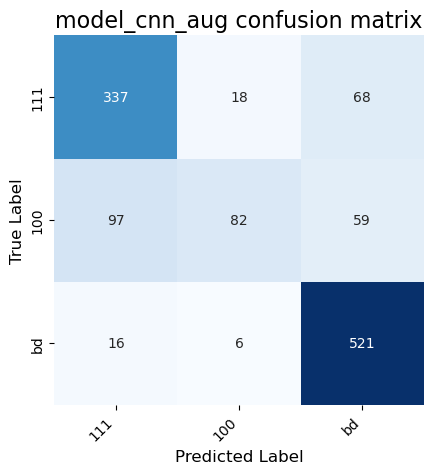

In [171]:
cm = confusion_matrix(y_true, y_pred_cnn_aug, labels=[0, 1, 2])
ax = sns.heatmap(cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False)
ax.set_title('model_cnn_aug confusion matrix', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.savefig(os.path.join(model_folder, 'model_cnn_aug_confusionmatrix.png'), dpi=300, bbox_inches='tight')

In [ ]:
Group_Reported_Accuracies = [0.71,0.73,0.74,0.75,0.71,0.73,0.74,0.75,0.71,0.73,0.74,0.75,0.75,0.75]

plt.hist(Group_Reported_Accuracies,edgecolor='k')
plt.xlabel("Validation Accuracy")
plt.ylabel("Count")
plt.show()

we can also use pandas to get a quick summary of the results

In [ ]:
import pandas as pd

In [ ]:
pd.Series(Group_Reported_Accuracies).describe()